In [2]:
import matplotlib as mpl

import os
import glob
import json
import re
import time

import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
import cPickle as pkl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches


In [6]:
import utils as util
import process_datafiles as procd
import aggregate_data as aggr

import assign_phase as ph
import scipy.stats as spstats

# Load data

In [7]:
rootdir = '/n/coxfs01/behavior-data'
paradigm = 'threeport'

processed_dir = os.path.join(rootdir, paradigm, 'processed')
metadata = util.get_metadata(paradigm, rootdir=rootdir, filtered=False, create_meta=False)


Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl


In [8]:
#### Get all animals in specified cohorts
#cohort_list = ['AK', 'AL', 'AM']
#cohort_list = ['AG', 'AJ']

cohort_list = ['AK', 'AL', 'AM'] #, 'AN'] #, 'AO']
excluded_animals = ['AM9', 'AM10', 'AM11', 'AM12']
cohortdf = aggr.combine_cohorts_to_dataframe(metadata, cohort_list=cohort_list, excluded_animals=excluded_animals)


('combining data from 3 cohorts:', ['AK', 'AL', 'AM'])
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... skipping AM10
... skipping AM11
... skipping AM12
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... skipping AM9


aggregate_data.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat(dflist, axis=0).reset_index(drop=True)


# Select phase

In [10]:
_ = ph.print_phase_lookup()

{   -1: 'other',
    0: 'always_reward',
    1: 'default',
    2: 'size',
    3: 'depth_rotation',
    4: 'cross',
    5: 'size_and_depth_rotation',
    6: 'depth_and_planar_rotation',
    7: 'morph',
    8: 'newstimuli',
    9: 'fine_grained_size',
    10: 'fine_grained_depth_rotation',
    11: 'fine_grained_size_and_depth_rotation',
    12: 'transparency',
    13: 'clutter',
    14: 'light_position',
    15: 'x_rotation',
    16: 'position',
    17: 'punishcycle_long',
    18: 'punishcycle_short',
    19: 'no_min_RT'}


In [11]:
#### Select phase to analyze
phase_list = [1, 2, 3, 4, 5]

#### Get data for current phase
df = aggr.get_cohort_data_by_phase(cohortdf, phase_list=phase_list, cohort_list=cohort_list)

Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl
... loading phase data...
/n/coxfs01/behavior-data/threeport/processed/meta/phases_AK.pkl
Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl
... loading phase data...
/n/coxfs01/behavior-data/threeport/processed/meta/phases_AL.pkl
Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl
... loading phase data...
/n/coxfs01/behavior-data/threeport/processed/meta/phases_AM.pkl


In [12]:
print("Phase:", sorted(df['phase'].unique()))

object_ids = df['objectid'].unique()
animal_ids = df['animalid'].unique()
print("%i unique animals" % len(animal_ids))
print("Object ids:", object_ids)

no_feedback_flag = len(df[df['no_feedback']==True])>0
print("Has no-feedback trials:", no_feedback_flag)
no_fb = {}

('Phase:', [1, 2, 3, 5])
36 unique animals
('Object ids:', array([2, 1]))
('Has no-feedback trials:', False)


# Check counterbalancing, portmapping, box info

In [15]:
#### Assign port mapping to df
portmapping = aggr.get_portmapping(df)
df['portmap'] = [0 for _ in np.arange(0, len(df))]
df.loc[df['animalid'].isin(portmapping['Object1_Port1']), 'portmap'] = 1


In [16]:
##### Assign box info
df, bboxes, towers = aggr.assign_box_info(df, metadata)


... getting tower info
... getting setup box info
32 of 36 animalids with unique setup box nos.
...loading existing multi-box info:
-->/n/coxfs01/behavior-data/threeport/processed/meta/multi_box_animals.json
Found 4 animals that were run in > 1 box


In [17]:
print("Towers:", df['tower'].unique())
print("Boxes:", sorted(df['boxnum'].unique()))


('Towers:', array([u'3', u'4', u'2'], dtype=object))
('Boxes:', [10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21])


# Create output dir

In [18]:
outdir = os.path.join(processed_dir, 'basic-training', 'standard-phases') #, 'phase-%i' % curr_phase, 'performance')
if not os.path.exists(outdir):
    print("making dir")
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/behavior-data/threeport/processed/basic-training/standard-phases


# Set common colors

In [19]:
tower_colors = dict((t, c) for t, c in zip(sorted(towers.keys(), key=util.natural_keys),
                                           sns.color_palette('colorblind', n_colors=len(towers.keys()))))
boxpos_colors = dict((t, c) for t, c in zip(np.arange(0, 4),
                                           sns.color_palette('cubehelix', n_colors=4)))

feature_colors = {'objectid': sns.color_palette('colorblind', n_colors=2),
                  'portmap': ['magenta', 'forestgreen'],
                  'twinx': ['tab:red', 'tab:blue'],
                  'tower': tower_colors,
                  'box_pos': boxpos_colors}


# Plotting functions

In [21]:
import plotting

In [22]:
# combine two color maps for 0-50% and 50-100% as in the PNAS paper
pnas_cmap = plotting.get_pnas_cmap()

# Font params
plotting.update_fonts(labelsize=24)

dpi=150


In [23]:
defaults = ph.get_default_params('AL')

default_size = defaults['size']
default_depth_rotation = defaults['depth_rotation']
default_planar_rotation = defaults['planar_rotation']

expected_sizes = defaults['expected_sizes']
expected_drots = defaults['expected_depth_rotations']

# default_size = 30
# default_depth_rotation = 0.
# default_planar_rotation = 0.

# if cohort in ['AL']:
#     expected_sizes = np.linspace(15, 40, 11.)
#     expected_drots = np.linspace(-60, 60, 25.)
#     default_size = 40
    
# elif cohort in ['AG']:
#     expected_sizes = np.linspace(15, 40, 6.)
#     expected_drots = np.linspace(-60, 60, 9.)


# expected_size_interval = np.diff(expected_sizes).mean()
# expected_drot_interval = np.diff(expected_drots).mean()


# Look at general stats

In [24]:
cohort_str = []
for cohort in cohort_list:
    anums = [int(re.search(r'(\d+)', a).group()) for a in animal_ids \
             if re.search(r'(\D+)', a).group()==cohort]
    cohort_str.append('%s%i-%i' % (cohort, min(anums), max(anums)))

#figid = 'phase%i_cohorts_%s\n%s' % (curr_phase, '-'.join(cohort_list), ' | '.join(cohort_str))
figid = 'phase%s_cohorts_%s\n%s' % ('-'.join([str(p) for p in phase_list]), '-'.join(cohort_list), ' | '.join(cohort_str))

print(figid)


phase1-2-3-4-5_cohorts_AK-AL-AM
AK1-12 | AL1-16 | AM1-8


In [25]:
start_t = time.time()

splitdf = [pd.DataFrame({'animalid': animalid,
                         'cohort': re.search(r'(\D+)', animalid).group(),
                          'session': int(re.search(r'(\d+)', sessionid).group()),
                          'sessionid': sessionid,
                          'objectid': objectid,
                          'boxnum': g['boxnum'].unique()[0],
                          'tower':  g['tower'].unique()[0],
                          'boxpos':  g['boxpos'].unique()[0],
                          'portmap':  g['portmap'].unique()[0],
                          'phase':  g['phase'].unique()[0],
                          'mean_rt': g['response_time'].mean(),
                          'split_accuracy': g['outcome'].value_counts()['success'] / float(g['outcome'].value_counts().sum()) \
                                    if 'success' in g['outcome'].value_counts().keys() else 0.,
                          'n_trials': float(g['outcome'].value_counts().sum())}, index=[i])\
                               for i, ((animalid, sessionid, objectid), g) \
                  in enumerate(df.groupby(['animalid', 'sessionid', 'objectid']))]
splitdf = pd.concat(splitdf, axis=0)
end_t = time.time() - start_t
print("Elapsed: {0:.2f}sec".format(end_t))

Elapsed: 16.15sec


In [26]:
start_t = time.time()
perfdf = [pd.DataFrame({'animalid': animalid,
                         'cohort': re.search(r'(\D+)', animalid).group(),
                          'session': int(re.search(r'(\d+)', sessionid).group()),
                          'sessionid': sessionid,
                          'boxnum': g['boxnum'].unique()[0],
                          'tower':  g['tower'].unique()[0],
                          'boxpos':  g['boxpos'].unique()[0],
                          'portmap':  g['portmap'].unique()[0],
                          'phase':  g['phase'].unique()[0],
                          'mean_rt': g['response_time'].mean(),
                          'overall_accuracy': g['outcome'].value_counts()['success'] / float(g['outcome'].value_counts().sum()) \
                                    if 'success' in g['outcome'].value_counts().keys() else 0.,
                          'n_trials': float(g['outcome'].value_counts().sum())}, index=[i])\
                               for i, ((animalid, sessionid), g) \
                  in enumerate(df.groupby(['animalid', 'sessionid']))]
perfdf = pd.concat(perfdf, axis=0)
end_t = time.time() - start_t
print("Elapsed: {0:.2f}sec".format(end_t))

Elapsed: 8.09sec


In [27]:
outdir

'/n/coxfs01/behavior-data/threeport/processed/basic-training/standard-phases'

# Visualize some overall stats

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

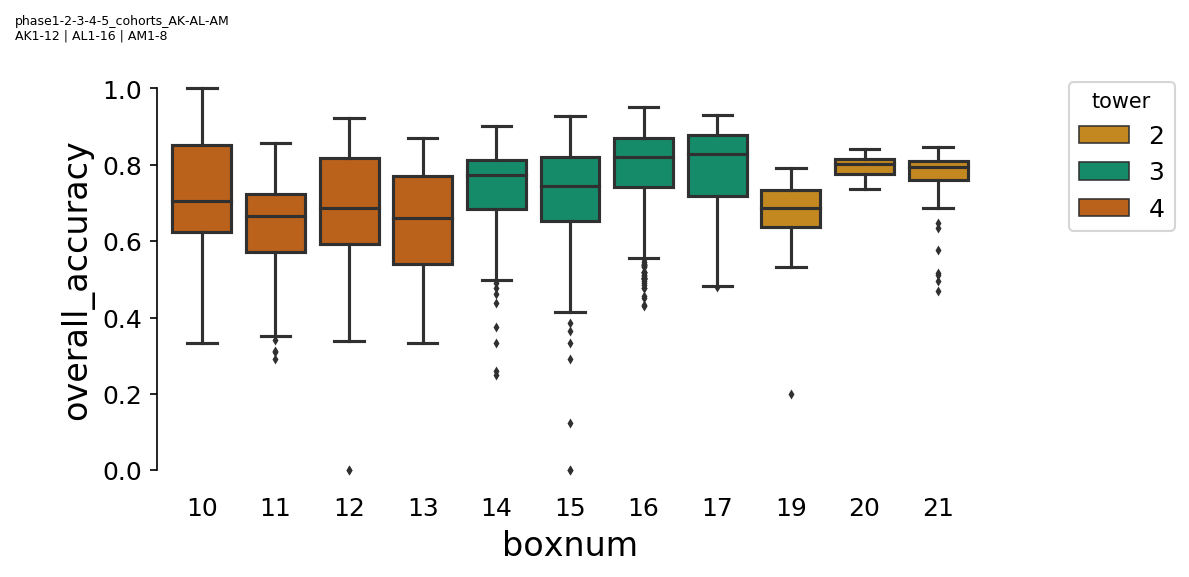

In [383]:
factor = 'boxnum'
hue = 'tower'

palette = feature_colors[hue] if hue in feature_colors.keys() else 'colorblind'

fig, ax = pl.subplots(figsize=(8,4), dpi=dpi)
sns.boxplot(x=factor, y='overall_accuracy', data=perfdf, ax=ax,
           fliersize=2, width=.8, hue=hue, dodge=hue!='tower', palette=palette)

sns.despine(trim=True, offset=4, bottom=True)
ax.tick_params(axis='x', size=0)
ax.legend(bbox_to_anchor=(1.1, 1), title=hue)
fig.text(0, 0.95, figid, fontsize=6)

pl.subplots_adjust(bottom=0.2, right=0.8, top=0.9)

figname = 'accuracy_by_%s_hue-%s_overall' % (factor, hue)
# pl.savefig(os.path.join(outdir, '%s.png' % figname))
# print(figname)
# print(outdir)

In [384]:
towers

{u'1': [22, 23, 24, 25],
 u'2': [18, 19, 20, 21],
 u'3': [14, 15, 16, 17],
 u'4': [10, 11, 12, 13]}

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


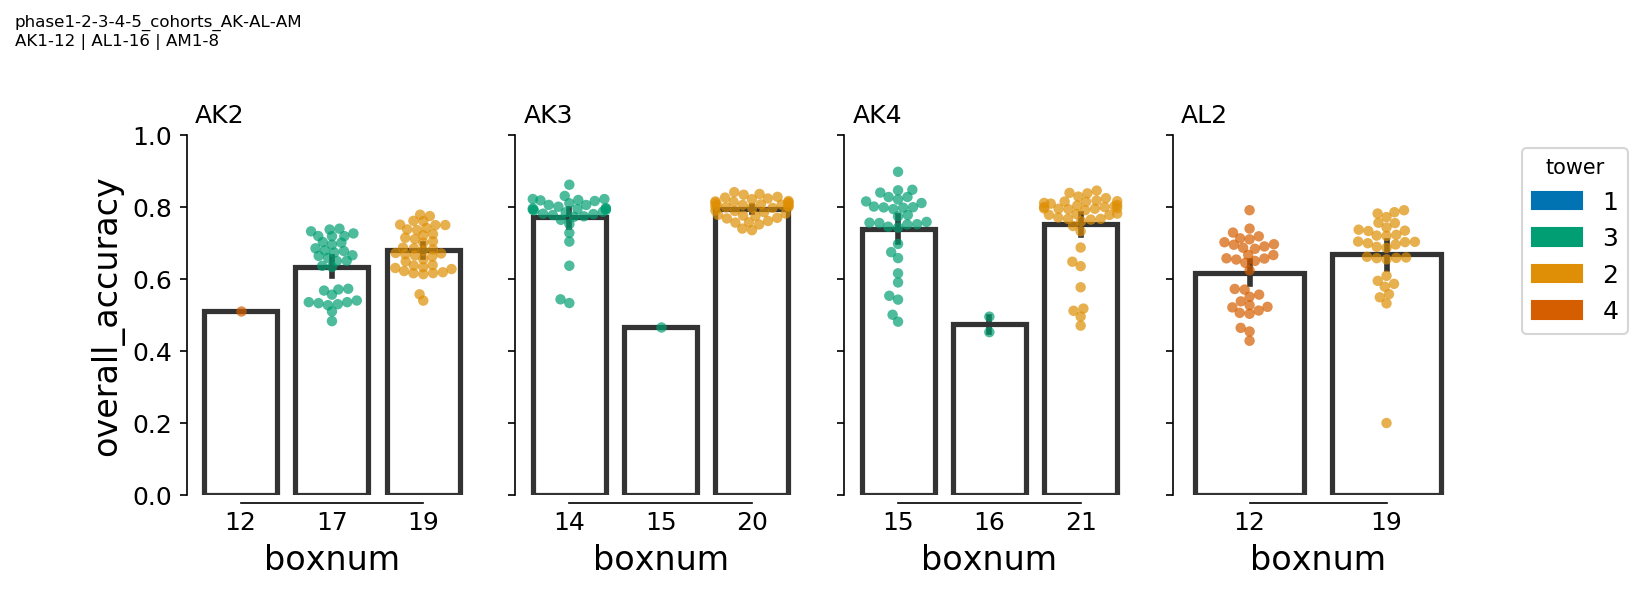

In [387]:
factor = 'boxnum'
split=False

metric = 'split_accuracy' if split else 'overall_accuracy'
tdf = splitdf.copy() if split else perfdf.copy()

fig, axes = pl.subplots(1, len(multi_box_animals), figsize=(12,4), dpi=dpi, sharex=False, sharey=True)
for ai, (ax, (animalid, pgroup)) in enumerate(zip(axes.flat, tdf[tdf['animalid'].isin(multi_box_animals)].groupby(['animalid']))):

    sns.barplot(x=factor, y=metric, data=pgroup, ax=ax,
               linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor=".2")

    sns.swarmplot(x=factor, y='overall_accuracy', data=pgroup, ax=ax, alpha=0.7,
                 hue='tower', palette=palette)
    
    # remove legend from axis 'ax'
    ax.legend_.remove()
    
    if ai!=0:
        ax.set_ylabel('')
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', size=0)
    sns.despine(trim=True, offset=4)
    ax.set_title(animalid, loc='left', fontsize=12)
    
fig.text(0, 0.95, figid, fontsize=8)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, wspace=0.2, top=0.8)
leg_patches = [mpatches.Patch(color=col, label=lab) for lab, col in feature_colors['tower'].items()]
pl.legend(handles=leg_patches, bbox_to_anchor=(1.2, 1), title='tower')


pl.savefig(os.path.join(outdir, 'multi_%s_accuracy_by-animal-plot-session-avg.png' % factor))

In [388]:
outdir

'/n/coxfs01/behavior-data/threeport/processed/basic-training/standard-phases'

## Plot accuracy by feature

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

tower_accuracy_boxplot_hue-cohort_
/n/coxfs01/behavior-data/threeport/processed/basic-training/standard-phases


/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

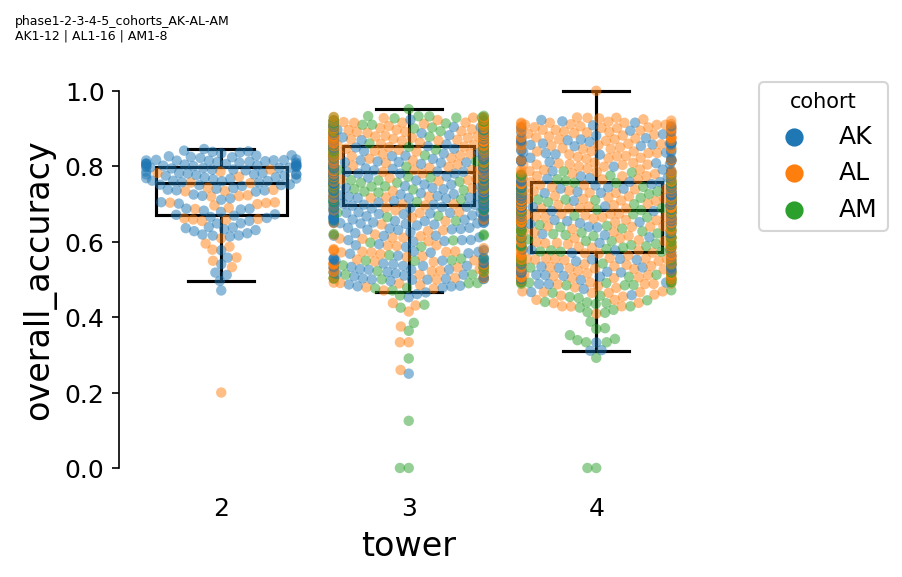

In [391]:
hue = 'cohort' #'cohort' # None
factor = 'tower'
plot_each_session = False


point_str = 'plot-each-session' if plot_each_session else ''
hue_str = 'hue-%s' % hue if hue is not None else ''
metric = 'split_accuracy' if split else 'overall_accuracy'

tdf = splitdf.copy() if 'object' in hue else perfdf.copy()
 
fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
sns.boxplot(x=factor, y=metric, data=tdf, ax=ax,
           fliersize=0, width=.7, dodge=True, color='white')

outline_boxplot(ax)

color = 'k' if hue is None else None
if plot_each_session or hue is not None:
    sns.swarmplot(x=factor, y=metric, data=tdf, ax=ax,
               hue=hue, color=color, alpha=0.5)

sns.despine(trim=True, offset=4, bottom=True)
ax.tick_params(axis='x', size=0)
if hue is not None:
    ax.legend(bbox_to_anchor=(1.1, 1), title=hue)

pl.subplots_adjust(bottom=0.2, right=0.75, top=0.9)
    
    
fig.text(0, 0.95, '%s' % (figid), fontsize=6)

figname = '%s_accuracy_boxplot_%s_%s' % (factor, hue_str, point_str)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print(figname)
print(outdir)

In [392]:
perfdf['portmap'].unique()

array([0, 1])

boxnum_overall-accuracy_hue-portmap_split-violin
/n/coxfs01/behavior-data/threeport/processed/basic-training/standard-phases


/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/julianarhee/an

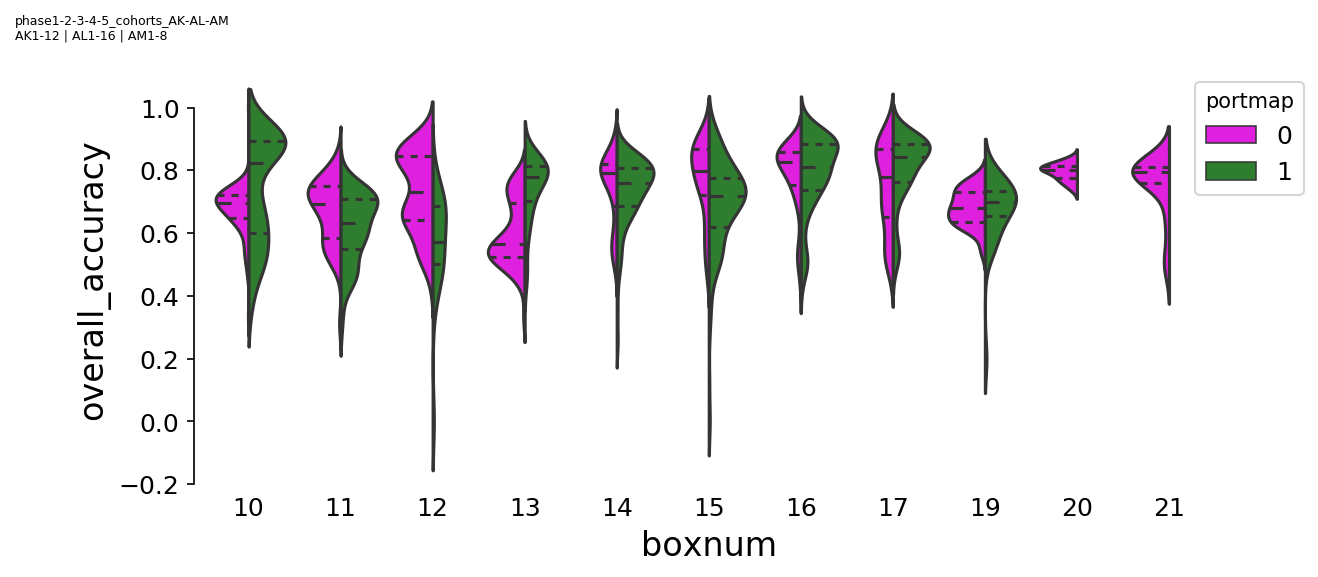

In [395]:
hue = 'portmap' #'portmap'
factor = 'boxnum' #'bbox'

curr_colors = feature_colors[hue]
split_plot = hue is not None
tdf = splitdf.copy() if hue=='objectid' else perfdf.copy()
metric = 'split_accuracy' if hue=='objectid' else 'overall_accuracy'
color = 'k' if hue is None else None
hue_str = 'hue-%s' % hue if hue is not None else ''
plot_type = 'violin' if hue is None else 'split-violin'


fig, ax = pl.subplots(figsize=(10,4), dpi=dpi)
sns.violinplot(x=factor, y=metric, data=tdf, ax=ax,
           hue=hue, split=split_plot, scale="count", inner="quartile", palette=curr_colors)

sns.despine(trim=True, offset=4, bottom=True)
ax.tick_params(axis='x', size=0)
if hue is not None:
    ax.legend(bbox_to_anchor=(1.1, 1), title=hue)
    
fig.text(0, 0.95, '%s' % (figid), fontsize=6)

pl.subplots_adjust(bottom=0.2, right=0.8, top=0.9)

figname = '%s_%s_%s_%s' % (factor, metric.replace('_', '-'), hue_str, plot_type)
print(figname)
print(outdir)

pl.savefig(os.path.join(outdir, '%s.png' % figname))


In [396]:
df['boxnum'].unique()

array([16, 15, 17, 12, 19, 14, 11, 10, 13, 20, 21])

# Stat test interactions

In [397]:
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
import statsmodels.api as sm


In [399]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor

standarddf_no0 = perfdf.copy()
#standarddf_no0 = standarddf_split[standarddf_split['bbox']!=0].copy()

model = ols('overall_accuracy ~ C(boxpos)*C(tower)', standarddf_no0).fit()

# Seeing if the overall model is significant
print("Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}".format(model=model))
    

Overall model F( 10, 2052) =  34.606, p =  0.0000


In [132]:
model.summary()

# The Durban-Watson tests is to detect the presence of autocorrelation, 
# Jarque-Bera tests the assumption of normality, 
# Omnibus tests the assumption of homogeneity of variance, 
# and the Condition Number assess multicollinearity. 
# Condition Number values over 20 are indicative of multicollinearity.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       overall_accuracy   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     36.64
Date:                Mon, 23 Mar 2020   Prob (F-statistic):           2.02e-69
Time:                        20:28:29   Log-Likelihood:                 1653.2
No. Observations:                4141   AIC:                            -3284.
Df Residuals:                    4130   BIC:                            -3215.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.6828      0.008     83.093      0.000       0.667       0.699
C(box_pos)[T.1]                  -0.0009      0.013     -0.071      0.944      -0.026       0.024
C(box_pos)[T.2]                   0.1129      0.016      7.270      0.000       0.082       0.143
C(box_pos)[T.3]                   0.0688      0.015      4.550      0.000       0.039       0.098
C(tower)[T.3]                     0.0545      0.009      5.947      0.000       0.037       0.072
C(tower)[T.4]                     0.0283      0.009      3.045      0.002       0.010       0.047
C(box_pos)[T.1]:C(tower)[T.3]    -0.0172      0.015     -1.167      0.243      -0.046       0.012
C(box_pos)[T.2]:C(tower)[T.3]    -0.0631      0.017     -3.687      0.000      -0.097      -0.030
C(box_pos)[T.3]:C(tower)[T.3]    -0.0239      0.017     -1.409      0.159      -0.057       0.009
C(box_pos)[T.1]:C(tower)[T.4]    -0.0600      0.015     -3.995      0.000      -0.089      -0.031
C(box_pos)[T.2]:C(tower)[T.4]    -0.1335      0.018     -7.373      0.000      -0.169      -0.098
C(box_pos)[T.3]:C(tower)[T.4]    -0.1215      0.017     -6.960      0.000      -0.156      -0.087
==============================================================================
Omnibus:                      676.177   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1312.881
Skew:                          -1.000   Prob(JB):                    8.16e-286
Kurtosis:                       4.899   Cond. No.                     5.22e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.65e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [133]:
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

sum_sq      df           F         PR(>F)
C(box_pos)             9.714767     3.0  122.572480   4.736522e-76
C(tower)              22.600990     2.0  427.739442  1.486439e-169
C(box_pos):C(tower)   12.287966     6.0   77.519430   4.347284e-92
Residual             109.110922  4130.0         NaN            NaN

In [134]:
mc = statsmodels.stats.multicomp.MultiComparison(standarddf_no0['overall_accuracy'], standarddf_no0['box_pos'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.0392  -0.0578 -0.0205  True 
  0      2     0.0319   0.0128  0.0511  True 
  0      3     0.006   -0.0133  0.0253 False 
  1      2     0.0711   0.0526  0.0897  True 
  1      3     0.0452   0.0264  0.064   True 
  2      3     -0.026  -0.0452 -0.0067  True 
---------------------------------------------


In [135]:
mc = statsmodels.stats.multicomp.MultiComparison(standarddf_no0['overall_accuracy'], standarddf_no0['tower'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  2      3     0.0282   0.0044  0.0519  True 
  2      4    -0.0521  -0.0763 -0.0278  True 
  3      4    -0.0803  -0.0929 -0.0676  True 
---------------------------------------------


In [137]:
vs = [g['overall_accuracy'].values for p, g in standarddf_no0.groupby(['box_pos'])]
spstats.kruskal(*vs)

KruskalResult(statistic=121.89501509307352, pvalue=3.014996668621372e-26)

In [138]:
vs = [g['overall_accuracy'].values for p, g in standarddf_no0.groupby(['tower'])]
spstats.kruskal(*vs)

KruskalResult(statistic=226.66763643007204, pvalue=6.02210240261235e-50)

In [139]:
vs = [g['overall_accuracy'].values for p, g in standarddf_no0.groupby(['bbox'])]
spstats.kruskal(*vs)

KruskalResult(statistic=383.7694447638502, pvalue=2.6703888607027964e-76)

# Look at performance as a function of time

In [458]:
pl.rcParams.update(mpl.rcParamsOrig)


In [459]:
update_fonts(big=True)

## Individuals

In [400]:
outdir

'/n/coxfs01/behavior-data/threeport/processed/basic-training/standard-phases'

In [401]:
if not os.path.exists(os.path.join(outdir, 'individuals')):
    os.makedirs(os.path.join(outdir, 'individuals'))


In [402]:
animal_ids

array(['AK1', 'AK10', 'AK11', 'AK12', 'AK2', 'AK3', 'AK4', 'AK5', 'AK6',
       'AK7', 'AK8', 'AK9', 'AL1', 'AL10', 'AL11', 'AL12', 'AL13', 'AL14',
       'AL15', 'AL16', 'AL2', 'AL3', 'AL4', 'AL5', 'AL6', 'AL7', 'AL8',
       'AL9', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5', 'AM6', 'AM7', 'AM8'],
      dtype=object)

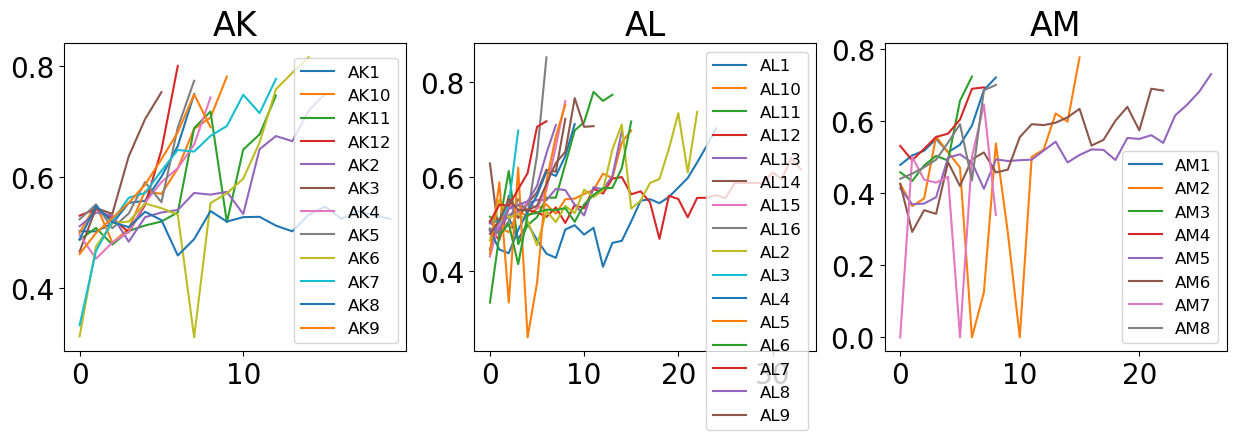

In [460]:
fig, axes = pl.subplots(1, len(cohort_list), figsize=(15, 4))

for (cohort, animalid), g in perfdf[perfdf['phase']==1].groupby(['cohort', 'animalid']):
    axi = list(cohort_list).index(cohort)
    ax = axes[axi]
    
    session_list = [s for s, sg in g.sort_values(by='sessionid').groupby(['sessionid'])]
    mean_acc = [sg['overall_accuracy'].values[0] for s, sg in g.sort_values(by='sessionid').groupby(['sessionid'])]
    ax.plot(np.arange(0, len(session_list)), mean_acc, label=animalid)
    #ax.plot(session_list, mean_acc)
    ax.set_title(cohort)
    ax.legend()

In [404]:
figsz = {'AK': (6, 2),
         'AL': (8, 2),
         'AM': (4, 2)}


(2, 6)
(2, 8)
(2, 4)


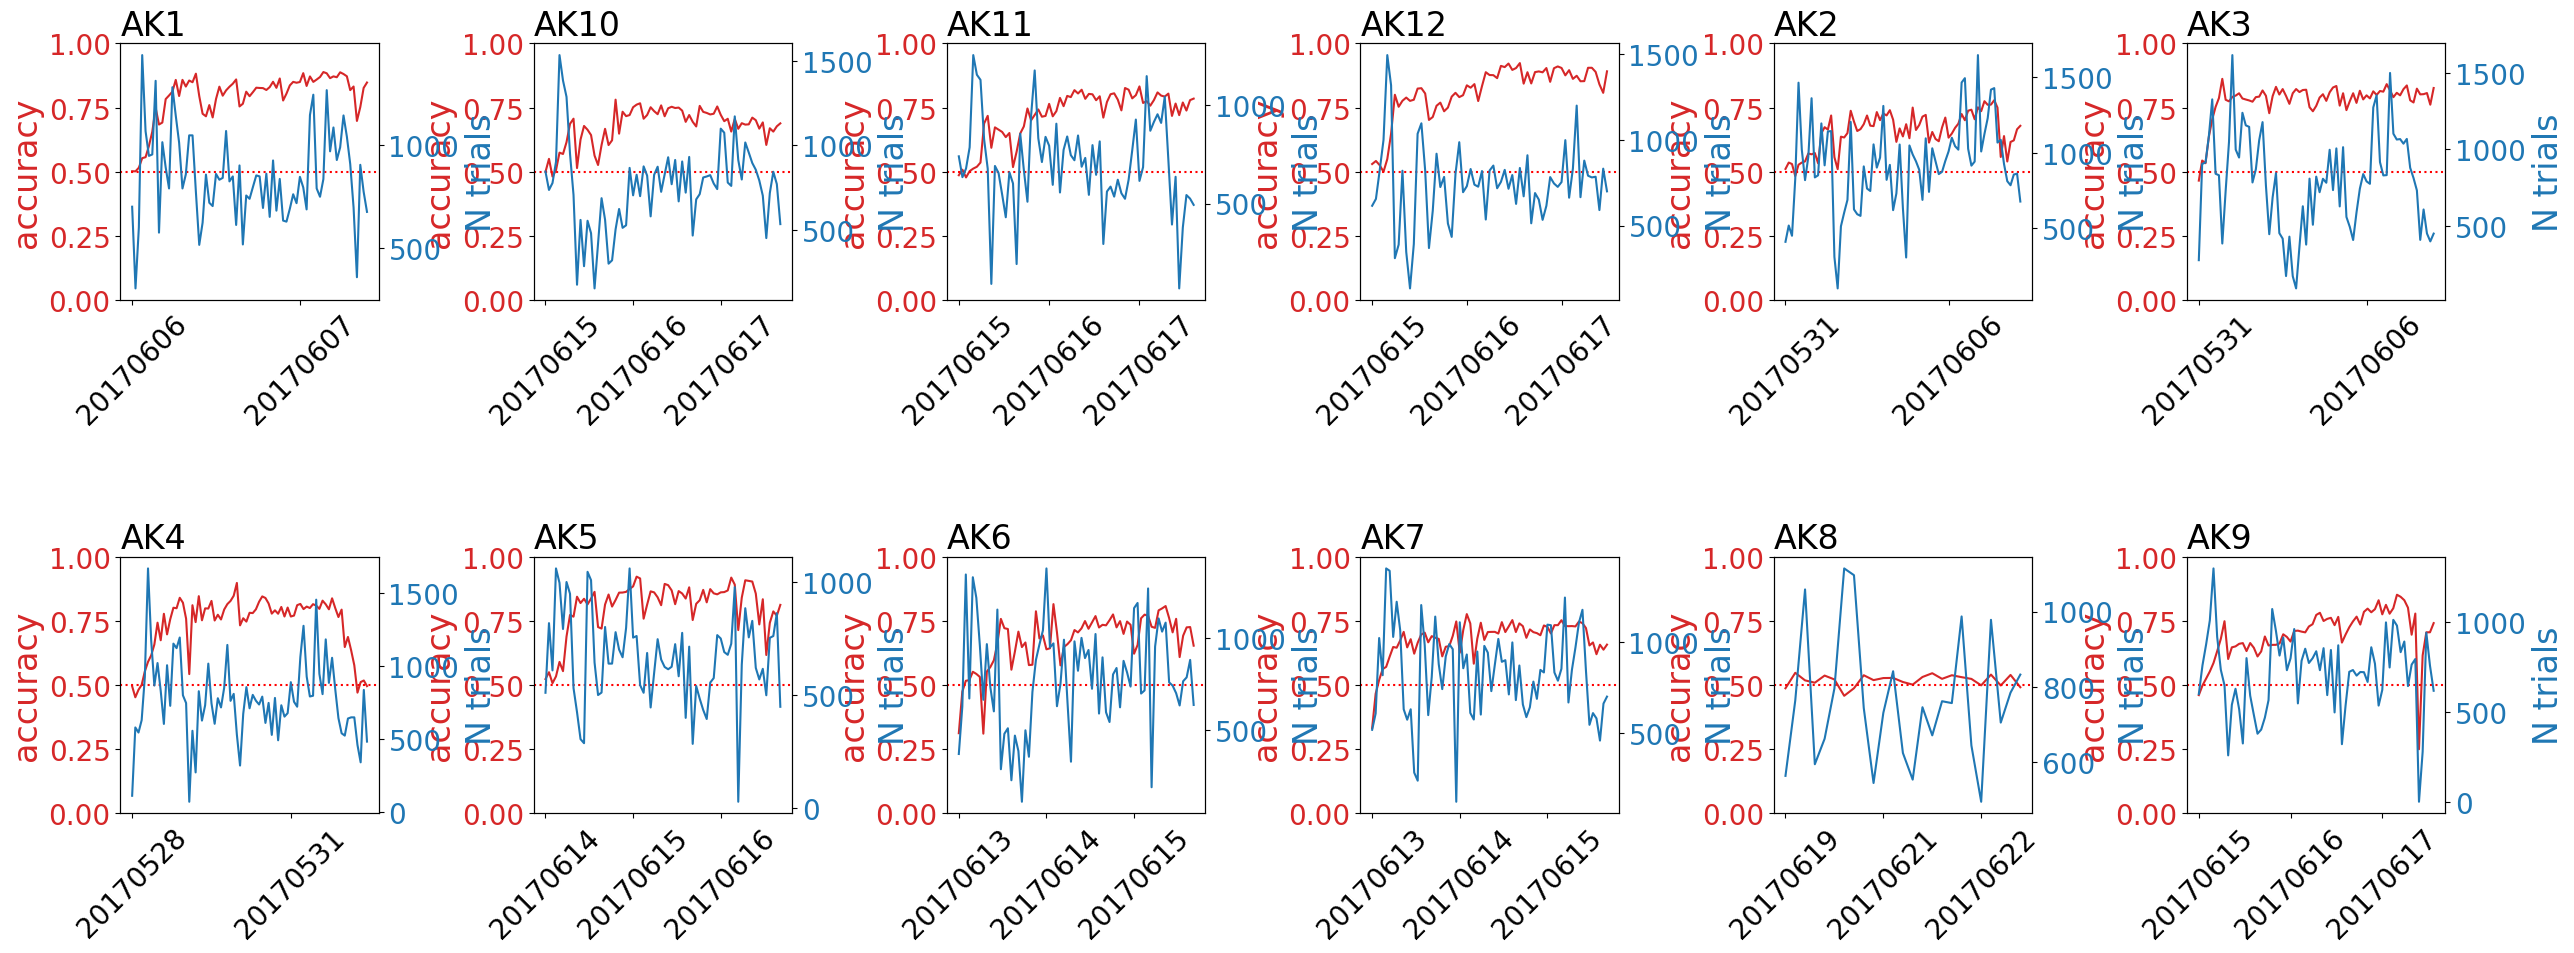

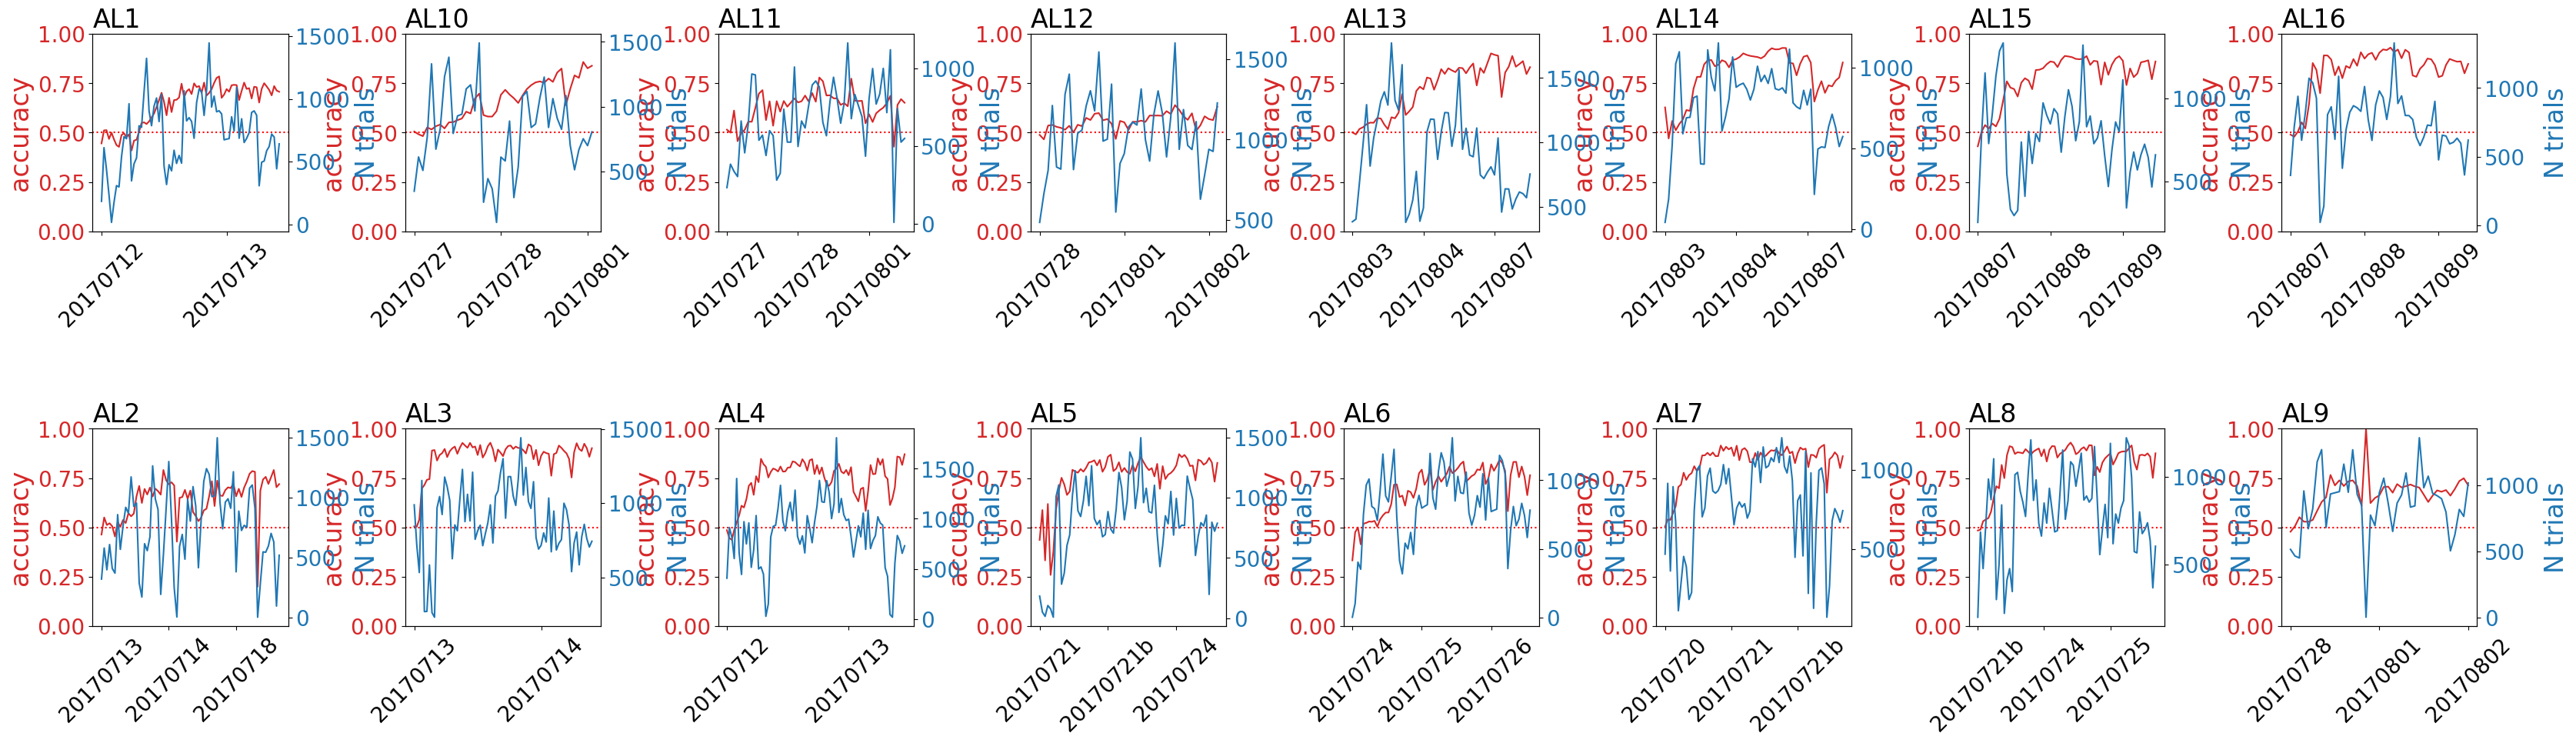

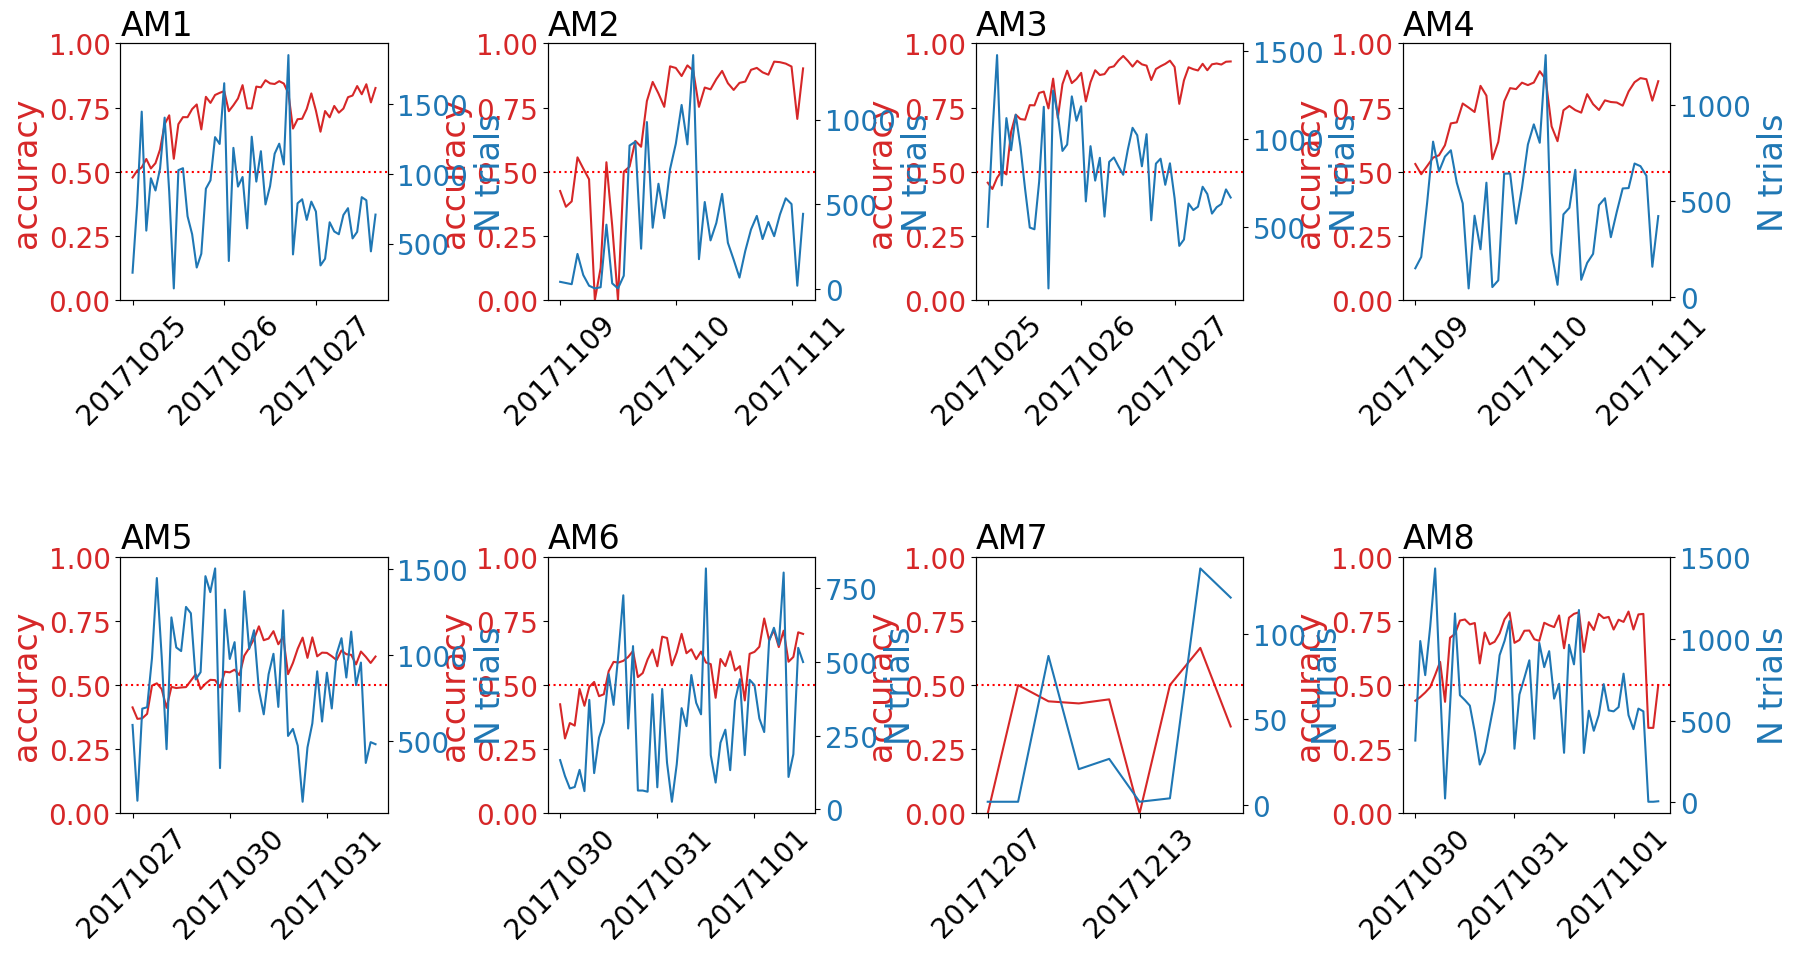

In [461]:
axis_colors = {0: 'tab:red', 1: 'tab:blue'}
figsz = {'AK': (6, 2),
         'AL': (8, 2),
         'AM': (4, 2)}

tdf =  perfdf.copy()

for cohort in tdf['cohort'].unique(): #curr_cohort_list:
    nc, nr = figsz[cohort]
    print(nr, nc)
    fig, axes = pl.subplots(nr, nc, figsize=(nc*5,nr*5))
    for ax, (animalid, ddf) in zip(axes.flat, tdf[tdf['cohort']==cohort].groupby(['animalid'])):

        xvs = [s for s, g in ddf.groupby(['sessionid'])]
        xis = np.arange(0, len(xvs))

        yvs= [g['overall_accuracy'].values[0] for s, g in ddf.groupby(['sessionid'])]
        ax.plot(xis, yvs, color=axis_colors[0])

        ax.tick_params(axis='y', labelcolor=axis_colors[0])
        ax.set_ylabel('accuracy', color=axis_colors[0])
        ax.set_ylim([0, 1])
        ax.axhline(y=0.5, linestyle=':', color='r')

        ax.set_xticklabels(xvs, rotation=45)
        #ax.tick_params(axis='x', rotation=45)

        ax2 = ax.twinx()
        twinvs = [g['n_trials'].values[0] for s, g in ddf.groupby(['sessionid'])]
        ax2.plot(xis, twinvs, color=axis_colors[1])
        ax2.tick_params(axis='y', labelcolor=axis_colors[1])
        ax2.set_ylabel('N trials', color=axis_colors[1])

        ax.set_title(animalid, loc='left')
        ax.set_xticklabels(xvs, rotation=45)

    pl.subplots_adjust(hspace=1, wspace=0.6)

    figname = '_by-animal_accuracy-and-ntrials_cohort-%s' % cohort

    pl.savefig(os.path.join(outdir, 'individuals', '%s.png' % figname))

(2, 6)
(2, 8)
(2, 4)


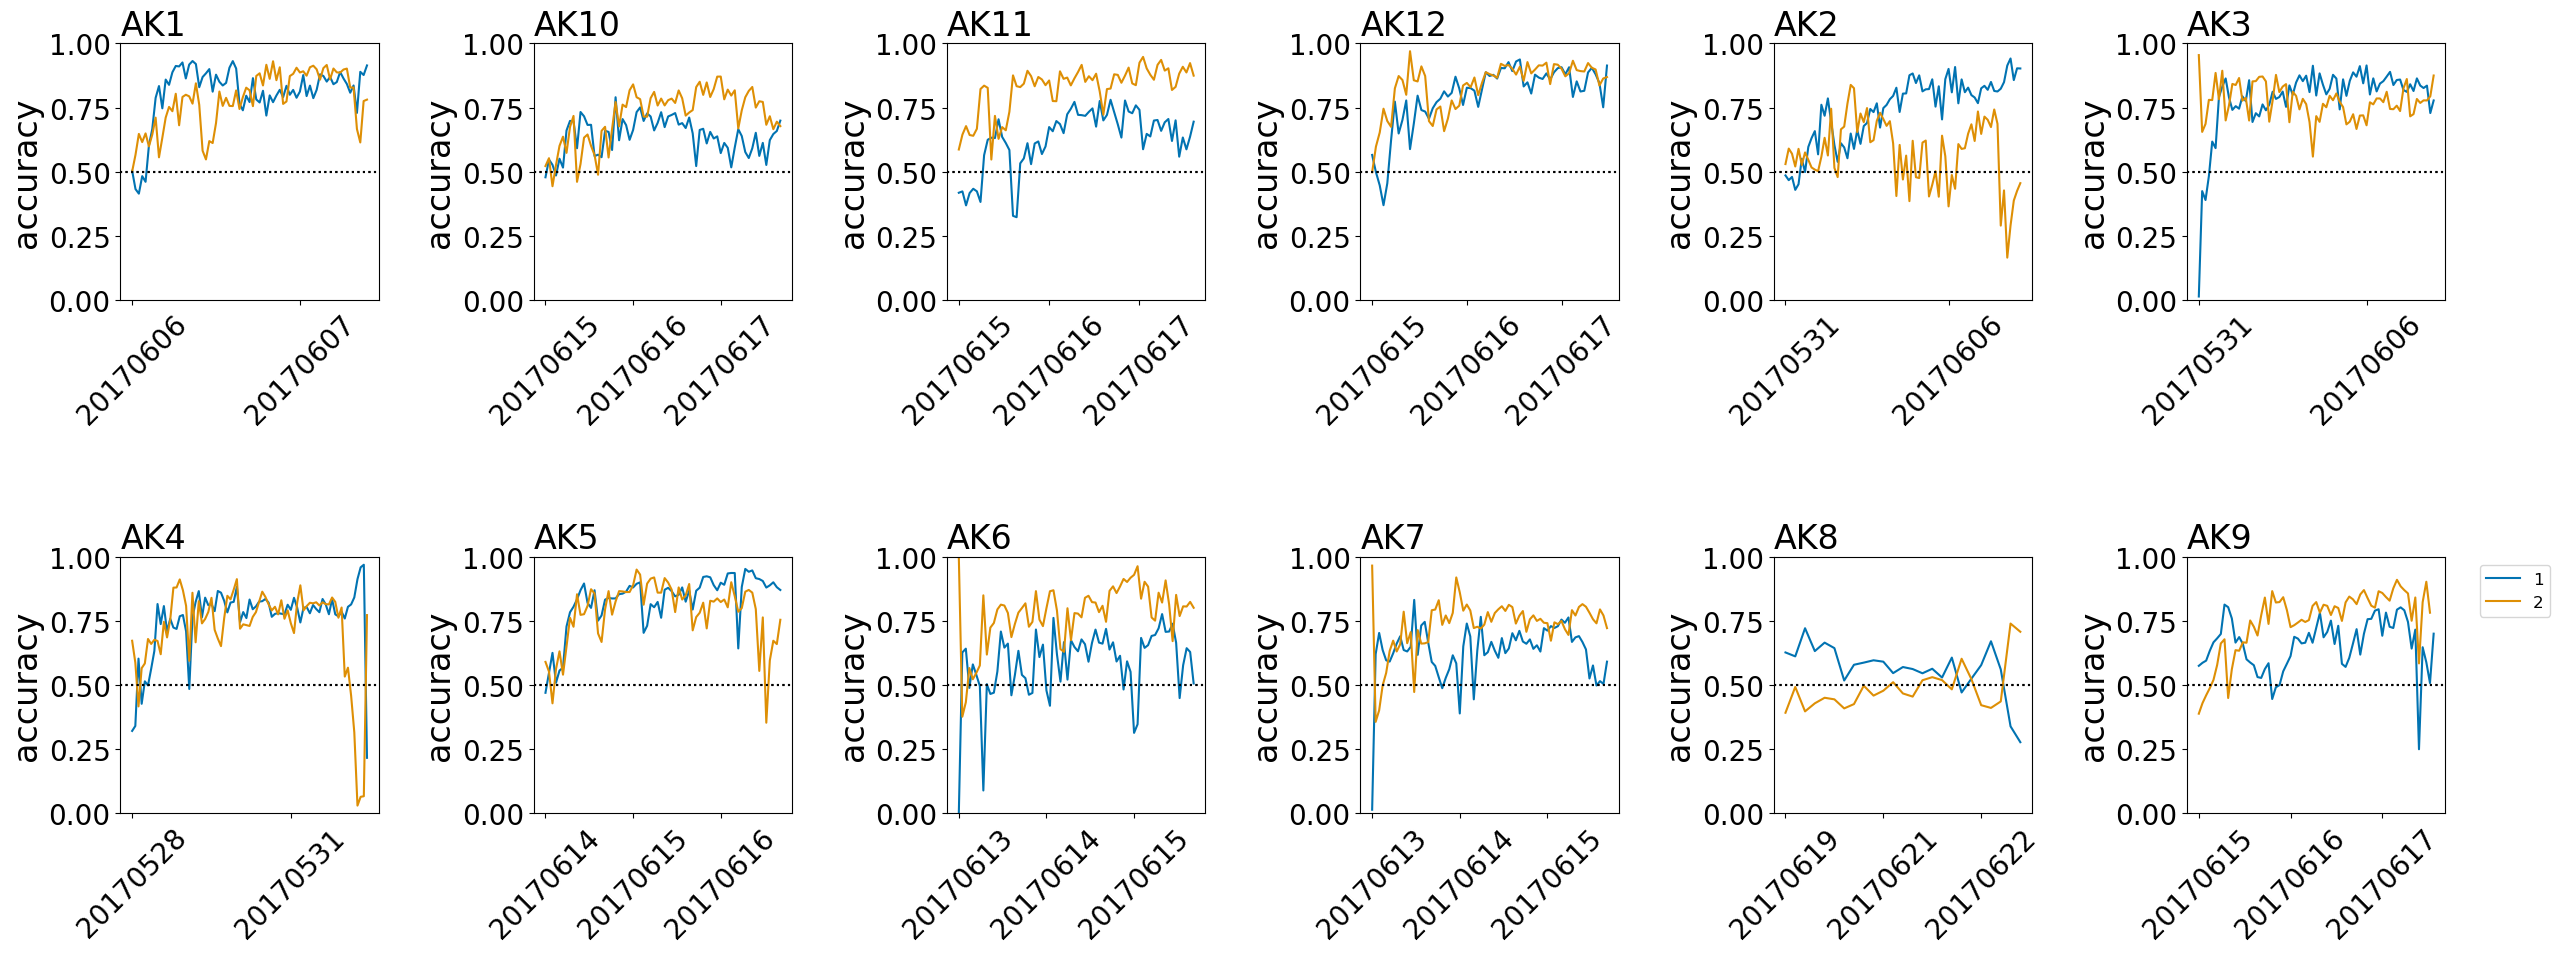

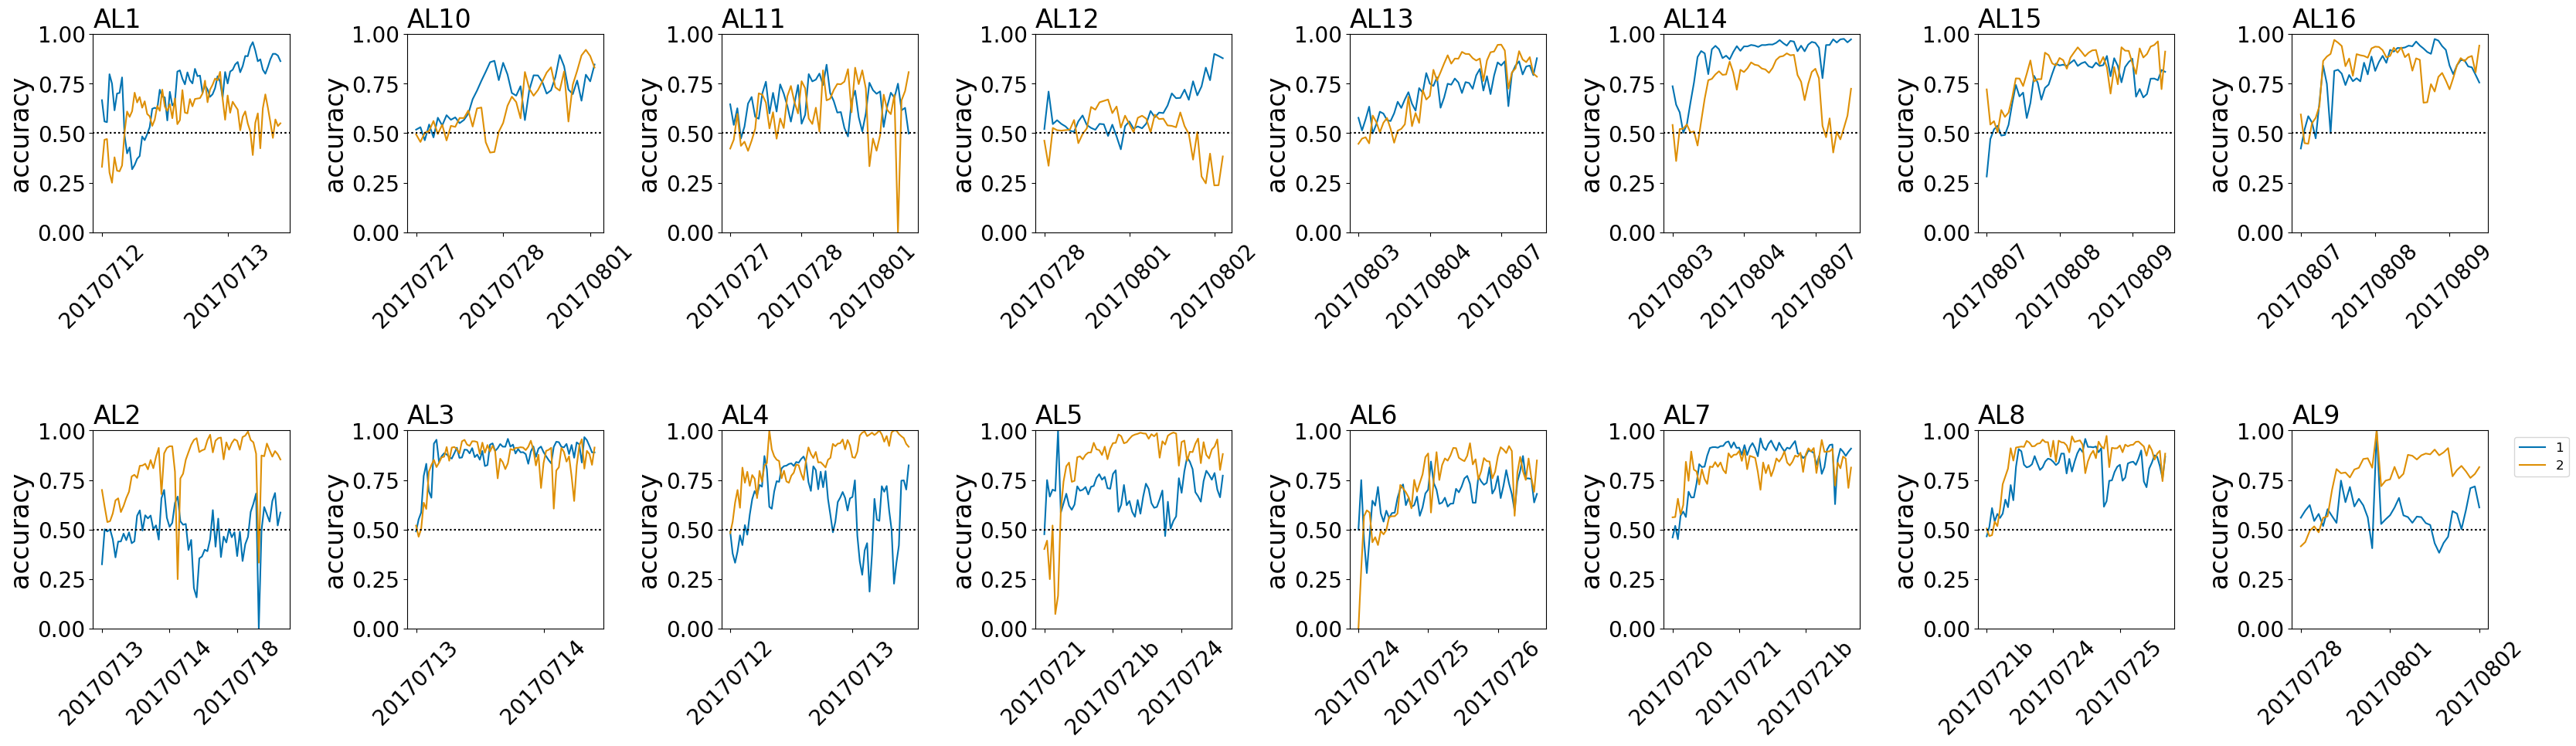

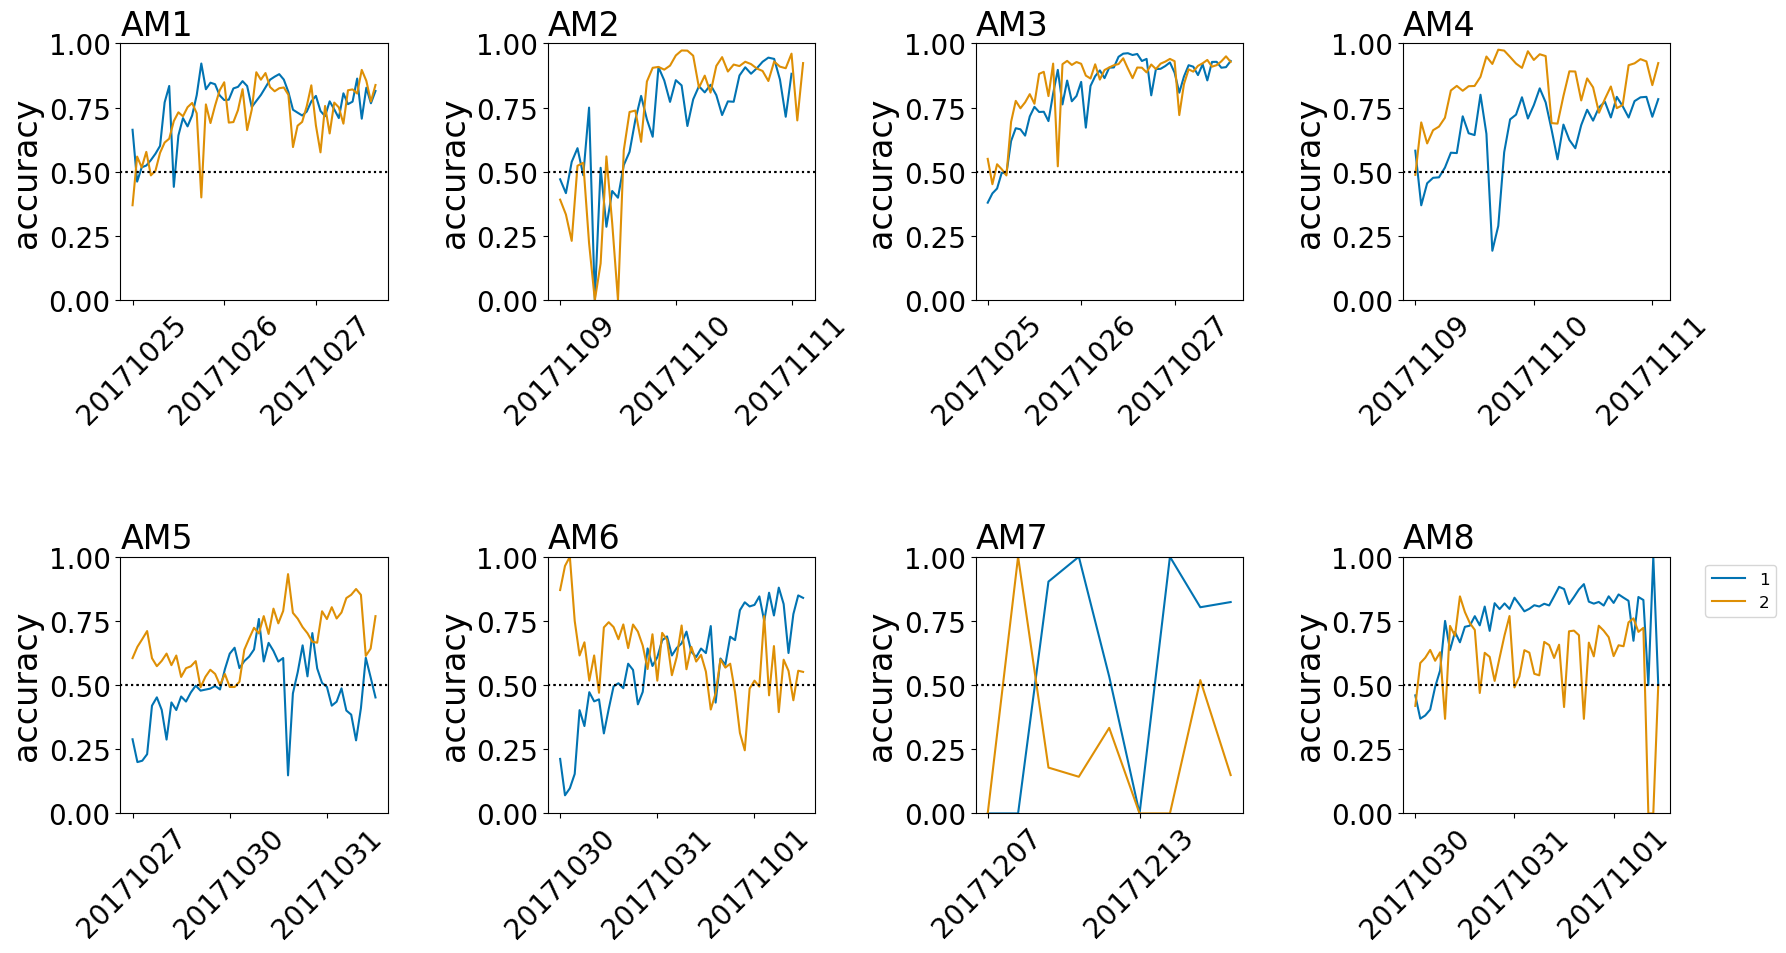

In [462]:
curr_colors = feature_colors['objectid']

figsz = {'AK': (6, 2),
         'AL': (8, 2),
         'AM': (4, 2)}

tdf =  splitdf.copy()


for cohort in tdf['cohort'].unique(): #curr_cohort_list:
    nc, nr = figsz[cohort]
    print(nr, nc)
    fig, axes = pl.subplots(nr, nc, figsize=(nc*5,nr*5))
    for ax, (animalid, animaldf) in zip(axes.flat, tdf[tdf['cohort']==cohort].groupby(['animalid'])):
    
        for c_color, ((objectid), odf) in zip(curr_colors, animaldf.groupby(['objectid'])):

            xvs = [s for s, g in odf.groupby(['sessionid'])]
            xis = np.arange(0, len(xvs))

            yvs= [g['split_accuracy'].values[0] for s, g in odf.groupby(['sessionid'])]
            ax.plot(xis, yvs, color=c_color, label=objectid)

            ax.set_ylabel('accuracy')
            ax.set_ylim([0, 1])
            ax.axhline(y=0.5, linestyle=':', color='k')

            ax.set_xticklabels(xvs, rotation=45)
            #ax.tick_params(axis='x', rotation=45)

            ax.set_title(animalid, loc='left')
            ax.set_xticklabels(xvs, rotation=45)

    pl.subplots_adjust(hspace=1, wspace=0.6)
    ax.legend(bbox_to_anchor=(1.1, 1))
    
    figname = '_by-animal_split-accuracy_objectid_cohort-%s' % cohort
    pl.savefig(os.path.join(outdir, 'individuals', '%s.png' % figname))

## Plot stuff for single example animal

In [463]:
animalid = 'AK12'
axis_colors = {0: feature_colors['twinx'][0], 
               1:  feature_colors['twinx'][1]}


animaldf = perfdf[perfdf['animalid']==animalid] 
animaldf['train_day'] = [-1 for _ in np.arange(0, len(animaldf))]

animaldf_split = splitdf[splitdf['animalid']==animalid].copy()
animaldf_split['train_day'] = [-1 for _ in np.arange(0, len(animaldf_split))]

for (animalid), g in animaldf.groupby(['animalid']):
    sorted_sessions = list(sorted(g['sessionid'].unique(), key=util.natural_keys))
    sorted_session_ixs = [sorted_sessions.index(s) for s in g['sessionid']]
    animaldf.loc[g.index, 'train_day'] = sorted_session_ixs
    
for (animalid), g in animaldf_split.groupby(['animalid']):
    sorted_sessions = list(sorted(g['sessionid'].unique(), key=util.natural_keys))
    sorted_session_ixs = [sorted_sessions.index(s) for s in g['sessionid']]
    animaldf_split.loc[g.index, 'train_day'] = sorted_session_ixs
    

last_session_in_phase = [g.sort_values(by='train_day')['train_day'].values[0] for p, g in animaldf.groupby(['phase'])]
# last_session_in_phase


/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


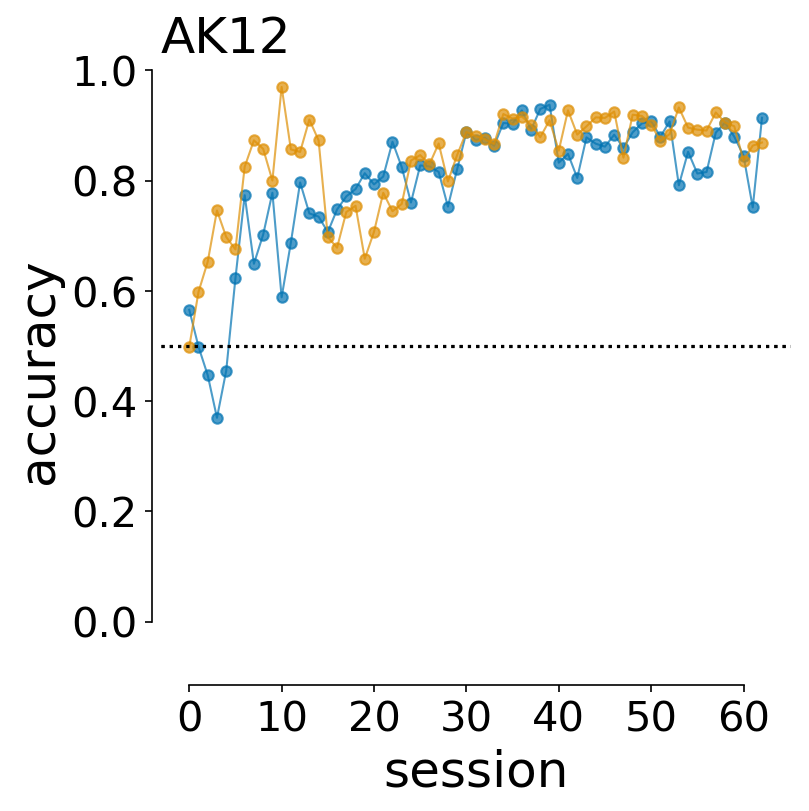

In [464]:
markersize=10
alpha=0.7
lw=1
marker='.'

curr_colors = feature_colors['objectid']
metric = 'split_accuracy'
fig, ax = pl.subplots(figsize=(7, 6), dpi=dpi)
for c_color, ((objectid), objectdf) in zip(curr_colors, animaldf_split.groupby(['objectid'])):

    session_list = [s for s, g in objectdf.groupby(['train_day'])]
    session_ixs = np.arange(0, len(session_list))
    xticks = [i for i in session_ixs if i%10==0]
    ax.set_xticks(xticks) #, rotation=45)
    ax.set_xticklabels(xticks) #, rotation=45)

    yvs= [g[metric].values[0] for s, g in objectdf.groupby(['train_day'])]
    ax.plot(session_ixs, yvs, color=c_color, label=objectid,
            marker=marker, lw=lw, alpha=alpha, markersize=markersize)

    ax.set_ylabel('accuracy')
    ax.set_ylim([0, 1])
    ax.axhline(y=0.5, linestyle=':', color='k')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)

    ax.set_title(animalid, loc='left')

# for phase_s in last_session_in_phase:
#     ax.axvline(x=phase_s, linestyle=':', color='k')
ax.set_ylim([-0.1, 1.01])

ax.set_xlabel('session')

pl.subplots_adjust(left=0.2, right=0.8, bottom=0.2)

sns.despine(offset=4, right=True, trim=True)

pl.savefig(os.path.join(outdir, 'individuals', 'split-accuracy_%s.svg' % animalid))


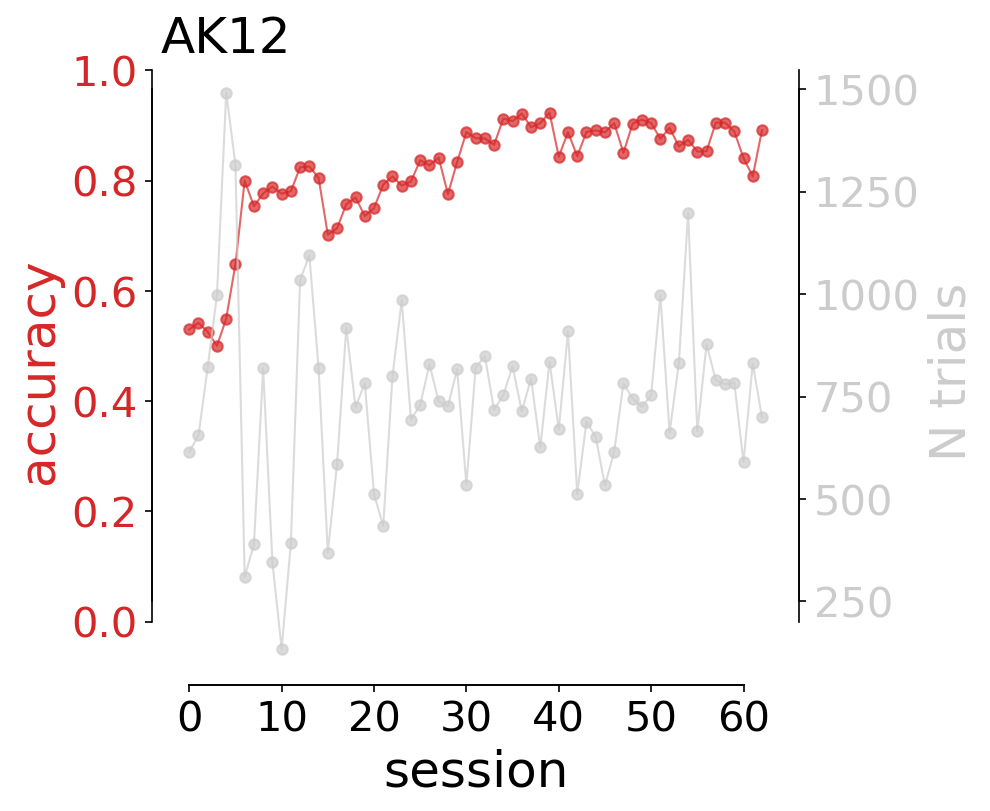

In [465]:

curr_colors = feature_colors['twinx']
curr_colors[1] = (0.8, 0.8, 0.8)

metric = 'overall_accuracy'

fig, ax = pl.subplots(figsize=(7, 6), dpi=dpi)
ax.set_title(animalid, loc='left')

session_list = [s for s, g in animaldf.groupby(['train_day'])]
session_ixs = np.arange(0, len(session_list))
xticks = [i for i in session_ixs if i%10==0]
ax.set_xticks(xticks) #, rotation=45)
ax.set_xticklabels(xticks) #, rotation=45)

yvs= [g[metric].values[0] for s, g in animaldf.groupby(['train_day'])]
ax.plot(session_ixs, yvs, color=curr_colors[0], 
                    marker=marker, lw=lw, alpha=alpha, markersize=markersize)

ax.tick_params(axis='y', labelcolor=curr_colors[0])
ax.set_ylabel('accuracy', color=curr_colors[0])
ax.set_ylim([-0.1, 1.01])
#ax.axhline(y=0.5, linestyle=':', color='r')

ax2 = ax.twinx()
yvs2 = [g['n_trials'].values[0] for s, g in animaldf.groupby(['train_day'])]
ax2.plot(session_ixs, yvs2, color=curr_colors[1], 
                     marker=marker, lw=lw, alpha=alpha, markersize=markersize)

ax2.tick_params(axis='y', labelcolor=curr_colors[1])
ax2.set_ylabel('N trials', color=curr_colors[1])

# for phase_s in last_session_in_phase:
#     ax.axvline(x=phase_s, linestyle=':', color='k')
ax.set_xlabel('session')

pl.subplots_adjust(left=0.2, right=0.8, bottom=0.2)
sns.despine(offset=4, right=False, trim=True)
pl.savefig(os.path.join(outdir, 'individuals', 'twinx_ntrials_accuracy_%s.svg' % animalid))


In [466]:
splitdf[splitdf['animalid']=='AK1'].iloc[-10:]


animalid  boxnum  boxpos cohort   mean_rt  n_trials  objectid  phase  \
132      AK1      16       2     AK  0.623646     348.0         1      5   
133      AK1      16       2     AK  0.732938     349.0         2      5   
134      AK1      16       2     AK  0.670965     181.0         1      5   
135      AK1      16       2     AK  0.765097     180.0         2      5   
136      AK1      16       2     AK  0.840844     452.0         1      5   
137      AK1      16       2     AK  0.831196     451.0         2      5   
138      AK1      16       2     AK  0.856279     390.0         1      5   
139      AK1      16       2     AK  0.885281     383.0         2      5   
140      AK1      16       2     AK  0.709383     338.0         1      5   
141      AK1      16       2     AK  0.760978     338.0         2      5   

     portmap   session sessionid  split_accuracy tower  
132        0  20171108  20171108        0.836207     3  
133        0  20171108  20171108        0.828080     3  
134        0  20180620  20180620        0.729282     3  
135        0  20180620  20180620        0.666667     3  
136        0  20180622  20180622        0.889381     3  
137        0  20180622  20180622        0.614191     3  
138        0  20180623  20180623        0.876923     3  
139        0  20180623  20180623        0.775457     3  
140        0  20180624  20180624        0.914201     3  
141        0  20180624  20180624        0.781065     3

# Visualize all animals

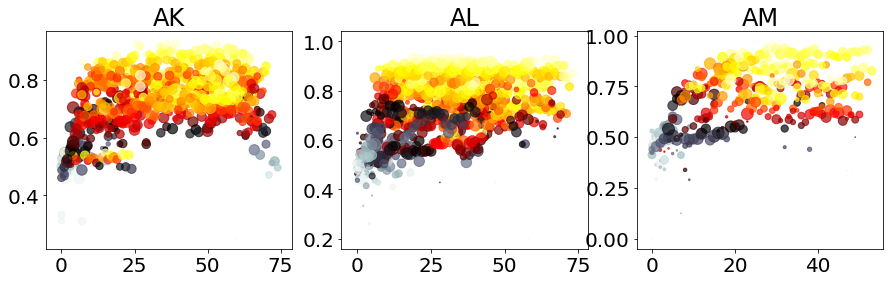

In [28]:
fig, axes = pl.subplots(1, len(cohort_list), figsize=(15, 4))

for (cohort, animalid), g in perfdf.groupby(['cohort', 'animalid']):
    axi = cohort_list.index(cohort)
    ax = axes[axi]
    
    session_list = [s for s, sg in g.sort_values(by='sessionid').groupby(['sessionid'])]
    mean_acc = [sg['overall_accuracy'].values[0] for s, sg in g.sort_values(by='sessionid').groupby(['sessionid'])]
    
    ntrials = [sg['n_trials'].values[0]/10. for s, sg in g.sort_values(by='sessionid').groupby(['sessionid'])]

    ax.scatter(np.arange(0, len(session_list)), mean_acc, c=mean_acc, cmap=pnas_cmap,
               s=ntrials, label=animalid, alpha=0.7)
    ax.set_title(cohort)


33 out of 36 animals with accuracy >= 0.70
('3 did not learn:', ['AK8', 'AL12', 'AM7'])


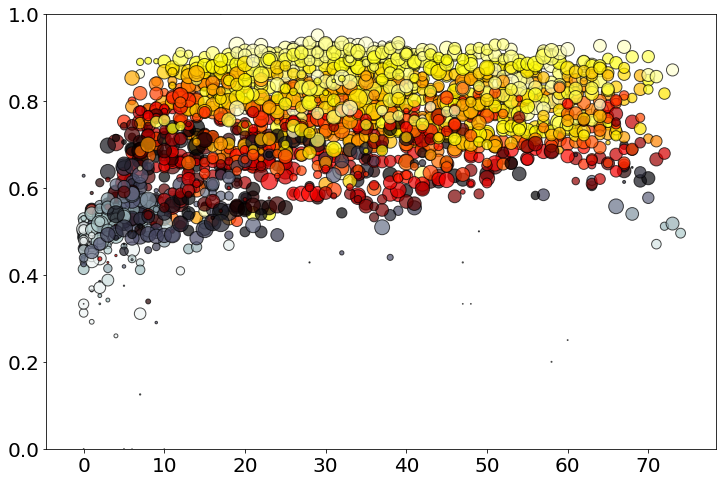

In [29]:
accuracies = {} # []
fig, ax = pl.subplots(figsize=(12, 8))

for (cohort, animalid), g in perfdf.groupby(['cohort', 'animalid']):
    
    session_list = [s for s, sg in g.sort_values(by='session').groupby(['sessionid'])]
    mean_acc = [sg['overall_accuracy'].values[0] for s, sg in g.sort_values(by='session').groupby(['sessionid'])]
    
    ntrials = [sg['n_trials'].values[0]/5. for s, sg in g.sort_values(by='session').groupby(['sessionid'])]
    
    accuracies.update({animalid: mean_acc})
    
    ax.scatter(np.arange(0, len(session_list)), mean_acc, c=mean_acc, cmap=pnas_cmap,
               s=ntrials, label=animalid, alpha=0.7, edgecolors='k')
    #ax.set_title(cohort)
    
ax.set_ylim([0, 1])

# Print sumamry
thr = 0.7
curr_animal_ids = perfdf['animalid'].unique()
animals_learned = perfdf[perfdf['overall_accuracy'] >= thr]['animalid'].unique()
print("%i out of %i animals with accuracy >= %.2f" % (len(animals_learned), len(curr_animal_ids), thr))
animals_didnt_learn = [i for i in curr_animal_ids if i not in animals_learned]

print("%i did not learn:" % len(animals_didnt_learn), animals_didnt_learn)


# Visualze all performance, sort sessions

In [30]:
max_nsessions = max([len(v) for k, v in accuracies.items()])
print(max_nsessions)

session_counts = dict((k, len(v)) for k, v in accuracies.items())

sorted_session_counts = [k for k, v in sorted(session_counts.items(), key=lambda x: x[1])][::-1] # np.argsort(session_counts)[::-1]


75


In [31]:
perfdf[perfdf.animalid=='AK4'].sort_values(by='session')[-10:]

animalid  boxnum  boxpos cohort   mean_rt  n_trials  overall_accuracy  \
477      AK4      21       3     AK  0.733567     643.0          0.765163   
478      AK4      21       3     AK  0.767588     539.0          0.794063   
479      AK4      21       3     AK  0.989482     523.0          0.648184   
480      AK4      21       3     AK  0.924106     640.0          0.687500   
481      AK4      21       3     AK  0.903301     648.0          0.635802   
482      AK4      21       3     AK  0.786564     648.0          0.577160   
483      AK4      21       3     AK  0.955058     459.0          0.470588   
484      AK4      21       3     AK  0.781887     340.0          0.511765   
485      AK4      21       3     AK  0.712357     836.0          0.517943   
486      AK4      21       3     AK  1.117915     482.0          0.495851   

     phase  portmap   session sessionid tower  
477      5        0  20171107  20171107     2  
478      5        0  20171108  20171108     2  
479      5        0  20180620  20180620     2  
480      5        0  20180621  20180621     2  
481      5        0  20180622  20180622     2  
482      5        0  20180623  20180623     2  
483      5        0  20180624  20180624     2  
484      5        0  20180625  20180625     2  
485      5        0  20180626  20180626     2  
486      5        0  20180627  20180627     2

In [32]:
#### Create array to plot as heatmap
performance_mat = np.empty((len(curr_animal_ids), max_nsessions))
for ai, animalid in enumerate(sorted_session_counts):
    vals = accuracies[animalid]
    xvpad = np.pad(vals, ((0, max_nsessions-len(vals))), mode='constant', constant_values=np.nan)

    performance_mat[ai, :] = xvpad

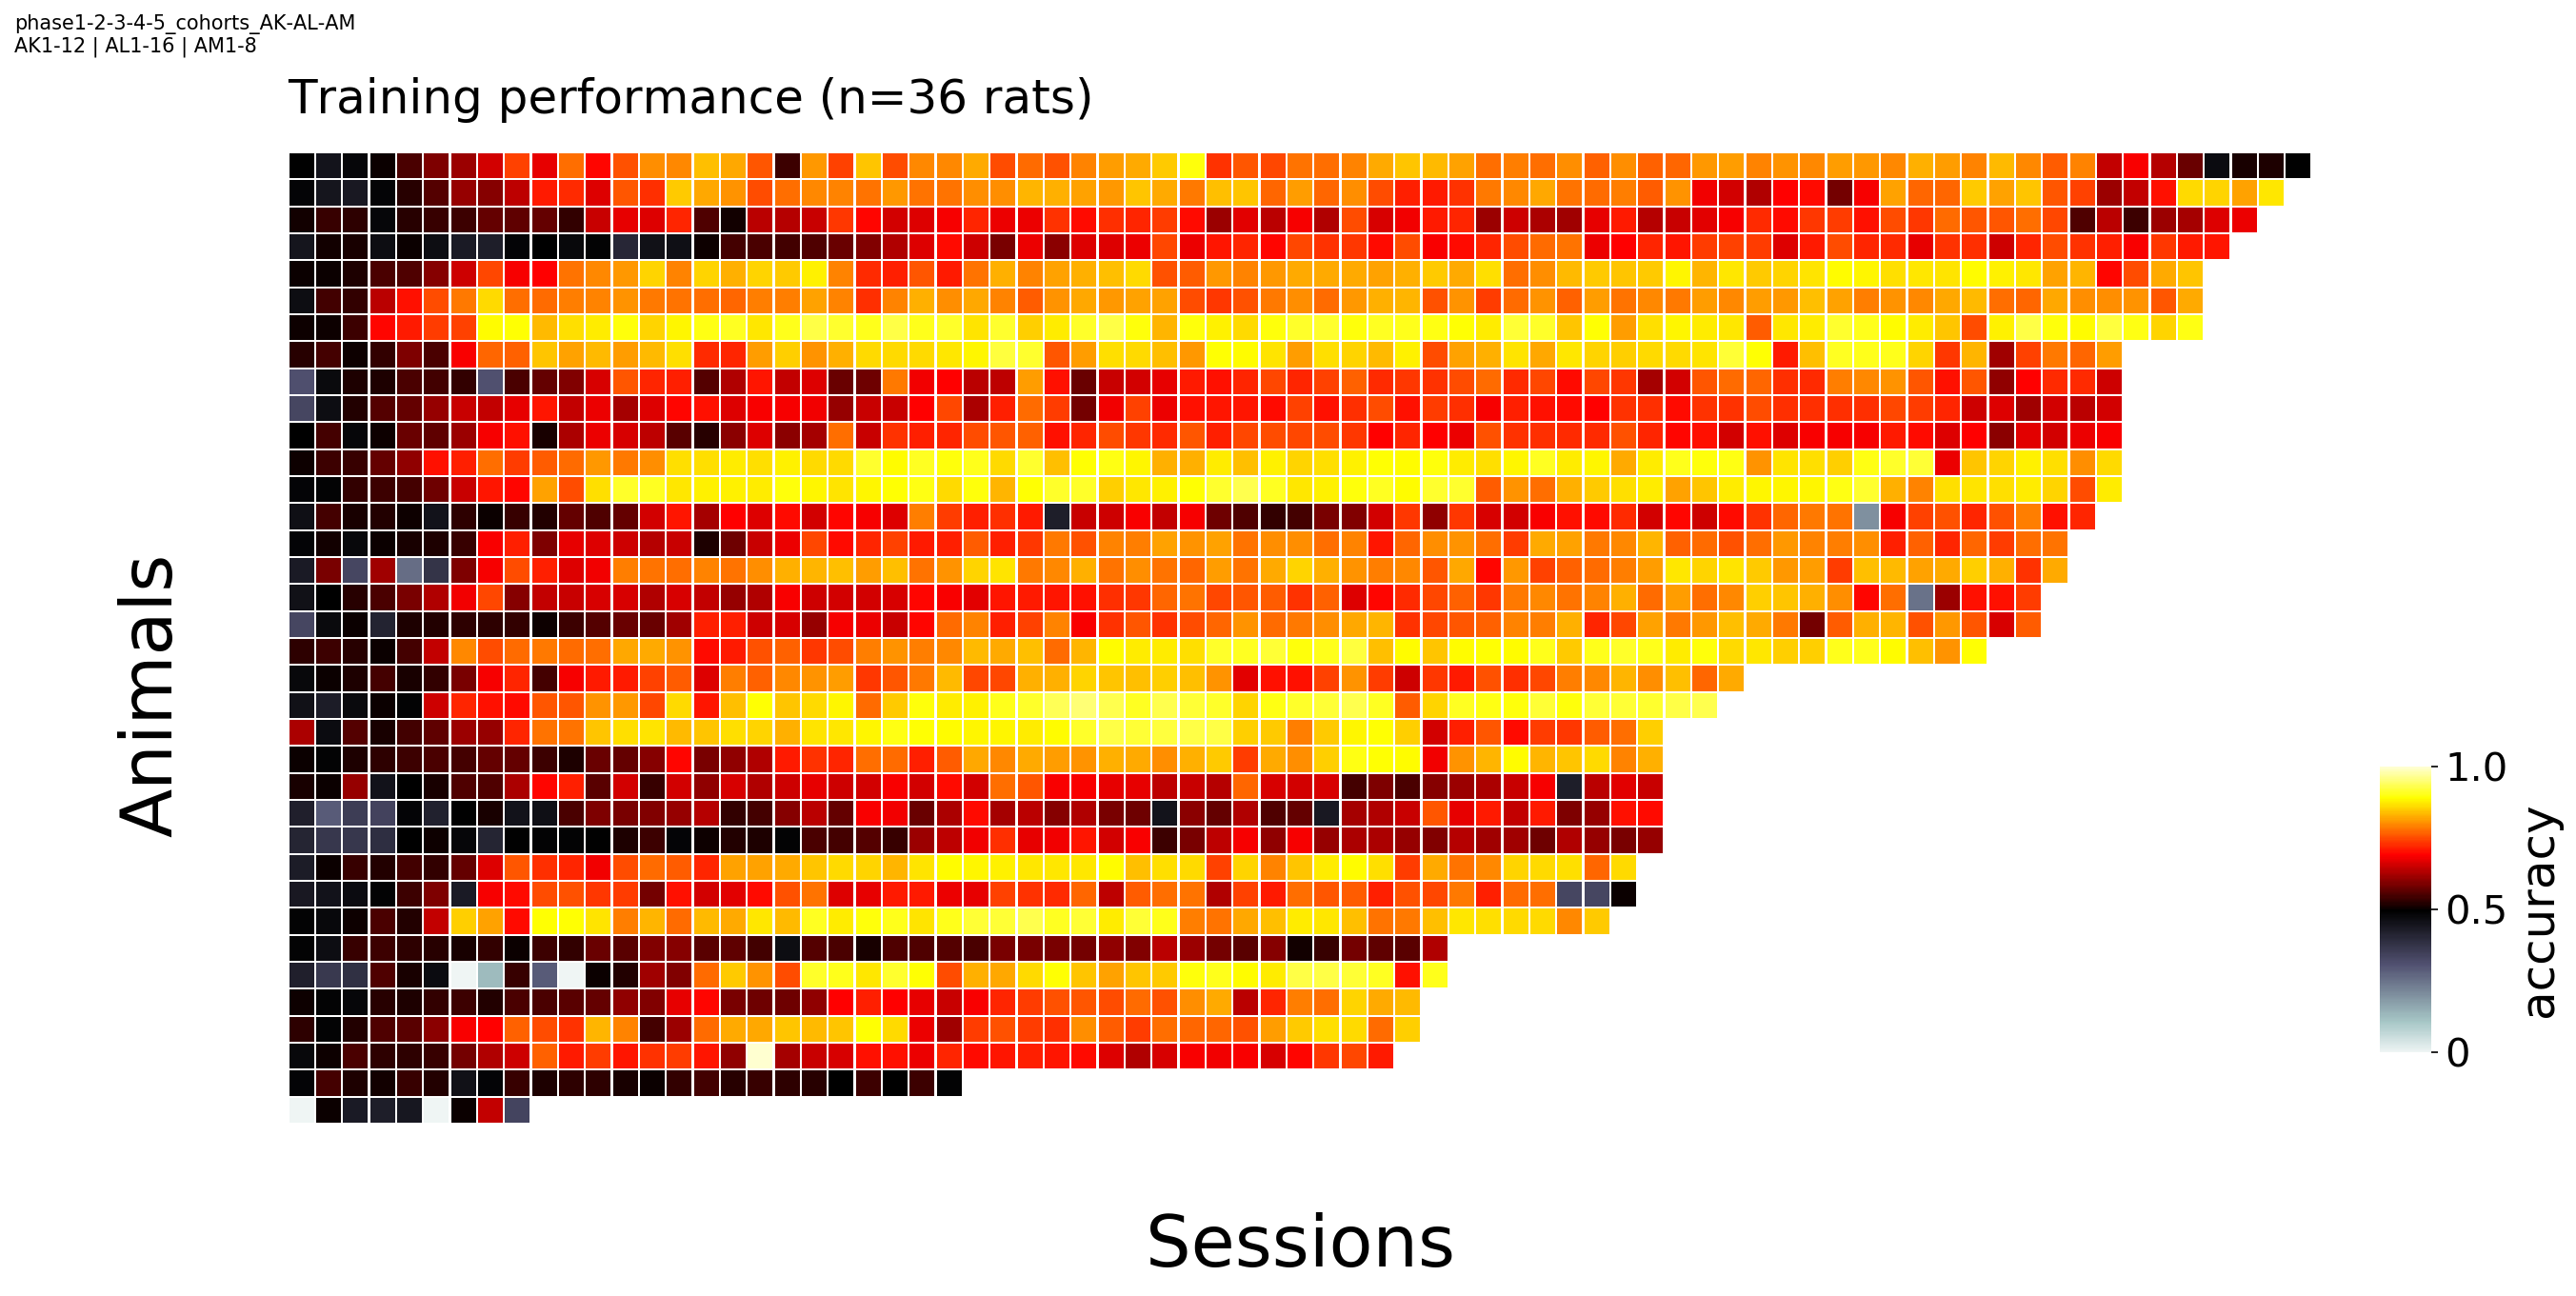

In [33]:
#### Plot performance array
fig, ax =pl.subplots(figsize=(18,10), dpi=dpi)
cbar_ax = fig.add_axes([.92, .25, .02, .2])
fig.patch.set_alpha(0.)
sns.heatmap(performance_mat, cmap=pnas_cmap, vmin=0, vmax=1, linewidths=0.5, square=True,
           cbar_ax=cbar_ax, cbar=1, ax=ax,
           cbar_kws=dict(ticks=[0, .5, 1.0]))
ax.tick_params(axis='x', size=0)
ax.axis('off')

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2)
ax.set_title('Training performance (n=%i rats)' % performance_mat.shape[0], loc='left', pad=20)

fig.text(0.5, 0.1, 'Sessions', ha='center', fontsize=36)
fig.text(0.04, 0.5, 'Animals', va='center', rotation='vertical', fontsize=36)

#cbar_ax.yaxis.label.set_size(20)
cbar_ax.set_yticklabels([0, 0.5, 1.0], fontsize=20) #(20)
cbar_ax.set_ylabel('accuracy', fontsize=24) #(20)

fig.text(0, 0.95, figid)
pl.savefig(os.path.join(outdir, '_heatmap_by_session_sorted2.png'))
pl.savefig(os.path.join(outdir, '_heatmap_by_session_sorted2.svg'))

In [480]:
df['size'].unique()

array([40. , 37.5, 35. , 32.5, 30. , 27.5, 25. , 22.5, 20. , 17.5, 15. ,
       12.5, 10. ])

In [481]:
df['depth_rotation'].unique()

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        -5, -10, -15, -20, -25, -30, -35, -40, -45, -50, -55, -60])

In [482]:
no_fb

{}

In [34]:
row_feature = 'size'
col_feature = 'depth_rotation'

row_values = sorted(df[row_feature].unique())

col_values = sorted(df[col_feature].unique())
feature_list = [row_feature, col_feature]

In [35]:
object_ids = df['object'].unique()
HMAPS = dict((animalid, dict((k, []) for k in object_ids)) for animalid in df['animalid'].unique())
no_feedback = {}

dlist = []

i=0
for (animalid, session, sfx), agroup in df.groupby(['animalid', 'session', 'suffix']):
    
    if any(p in [4, 5] for p in phase_list) and no_feedback_flag is True:
        no_fb = agroup[agroup['no_feedback']==True][feature_list]
        no_fb_configs = list(set([(s, d) for s, d, in zip(no_fb[row_feature].values, no_fb[col_feature].values)]))
        no_feedback[animalid] = no_fb_configs

    for objectname, ogroup in agroup.groupby(['object']):
        hmap = np.ones((len(row_values), len(col_values))) * np.nan

        for (drot, sz), sgroup in ogroup.groupby([col_feature, row_feature]):

            n_trials = float(sgroup['outcome'].shape[0])
            perc_correct = len(sgroup[sgroup['outcome']=='success']) / n_trials
            mean_rt = sgroup['response_time'].mean()

            r_ix = list(row_values).index(sz)
            c_ix = list(col_values).index(drot)

            hmap[r_ix, c_ix] = perc_correct

            dlist.append(pd.DataFrame({'perc_correct': perc_correct,
                                       'avg_rt': mean_rt,
                                          'n_trials': n_trials,
                                          '%s' % row_feature: sz,
                                          '%s' % col_feature: drot,
                                          'objectid': objectname,
                                          'animalid': animalid,
                                          'session': session,
                                          'suffix': sfx,
                                        'phase': sgroup['phase'].unique()[0]}, index=[i]))
            i+=1

        HMAPS[animalid][objectname].append(hmap)

heatdf = pd.concat(dlist, axis=0)       

for animalid, hmap_d in HMAPS.items():
    HMAPS[animalid] = dict((k, np.dstack(v)) for k, v in hmap_d.items())


In [138]:
df['phase'].unique()

array([1, 2, 3, 5])

# General performance and RT

In [139]:
import itertools

In [140]:
expected_sizes = df[df['phase'].isin([1, 2, 3])]['size'].unique()
expected_drots = df[df['phase'].isin([1, 2, 3])]['depth_rotation'].unique()

In [143]:
# df[df['phase'].isin([4,5])].groupby(['size', 'depth_rotation']).count()
default_size = 40.
default_depth_rotaton = 0.

In [167]:
training_phases = [2, 3]

In [145]:
all_combos = list(itertools.product(expected_sizes, expected_drots))

cross_views = [(default_size, rot) for rot in expected_drots]
cross_views.extend([(sz, default_depth_rotation) for sz in expected_sizes])
cross_views


offcross_views = [c for c in all_combos if c not in cross_views]

In [147]:
df['phase'].unique()

array([1, 2, 3, 5])

In [168]:
traindf = heatdf[heatdf['phase'].isin(training_phases)]
traindf['sessionid'] = ['%s%s' % (sess, sfx) for sess, sfx in traindf[['session', 'suffix']].values]

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [169]:
traindf['size'].unique()

array([20. , 22.5, 25. , 27.5, 30. , 32.5, 35. , 37.5, 40. , 10. , 12.5,
       15. , 17.5])

In [234]:
mean_acc_by_size = traindf[traindf['depth_rotation']==default_depth_rotation].groupby(['size', 'animalid']).mean()['perc_correct']
mean_acc_by_size = mean_acc_by_size.reset_index()
mean_acc_by_drot = traindf[traindf['size']==30.].groupby(['depth_rotation', 'animalid']).mean()['perc_correct']
mean_acc_by_drot = mean_acc_by_drot.reset_index()


In [235]:
default_size

40.0

In [247]:
print("N sizes:", len(mean_acc_by_size['size'].unique()))
print("N d-rots:", len(mean_acc_by_drot['depth_rotation'].unique()))


('N sizes:', 13)
('N d-rots:', 25)


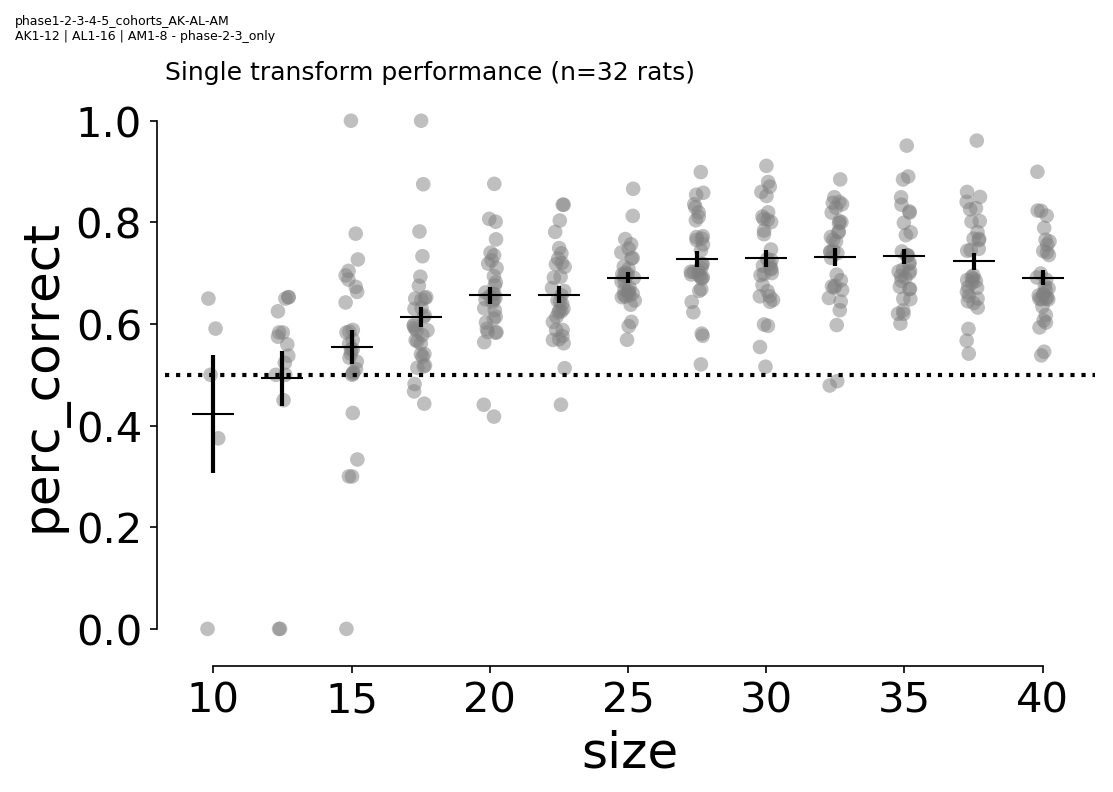

In [250]:

curr_transform = 'size'

if curr_transform=='size':
    currdf = mean_acc_by_size.copy()
elif curr_transform == 'depth_rotation':
    currdf = mean_acc_by_drot.copy()
    
transform_vals = [s for s, g in currdf.groupby([curr_transform])]
n_transforms = len(transform_vals)

fw = min([n_transforms, 8])

fig, ax = pl.subplots(figsize=(fw, 5), dpi=dpi)
sns.stripplot(x=curr_transform, y='perc_correct', data=currdf, ax=ax, zorder=0,
             alpha=0.5, size=7, color='gray')

meanvals = [g['perc_correct'].mean() for s, g in currdf.groupby([curr_transform])]
semvals = [spstats.sem(g['perc_correct'].values) for s, g in currdf.groupby([curr_transform])]

ax.plot(np.arange(0, len(transform_vals)), meanvals, lw=0, 
        marker='_', markersize=20, color='k')
ax.errorbar(np.arange(0, len(transform_vals)), meanvals, yerr=semvals, lw=0, 
        color='k', elinewidth=2, capsize=0)
ax.axhline(y=0.5, linestyle=':', lw=2, color='k')

xtick_ixs = np.arange(0, len(transform_vals))[0::2]
ax.set_xticks(xtick_ixs)
xticks = [int(i) for i in transform_vals[0::2]]
ax.set_xticklabels(xticks)
sns.despine(trim=True, offset=4)
n_rats = len(mean_acc_by_size['animalid'].unique())

ax.set_title('Single transform performance (n=%i rats)' % n_rats, loc='left', fontsize=12)
fig.text(0, 0.95, '%s - phase-2-3_only' % figid, fontsize=6)

figname = 'single_transform_performance_%s' % curr_transform
pl.savefig(os.path.join(outdir, '%s.svg' % figname))


In [241]:
len(mean_acc_by_size['animalid'].unique())


32

In [44]:
firstdf.head()

objectid  size  depth_rotation  success animalid
0         1  10.0               0        1      AK1
1         1  12.5               0        0      AK1
2         1  15.0               0        0      AK1
3         1  17.5               0        0      AK1
4         1  20.0               0        1      AK1

In [57]:
for (sz), g in firstdf.groupby(['size']):
    print(sz, g[g['depth_rotation']==0].groupby(['animalid']).mean()['success'].mean())

(10.0, 0.6)
(12.5, 0.5)
(15.0, 0.5714285714285714)
(17.5, 0.53125)
(20.0, 0.609375)
(22.5, 0.734375)
(25.0, 0.671875)
(27.5, 0.703125)
(30.0, 0.625)
(32.5, 0.671875)
(35.0, 0.71875)
(37.5, 0.734375)
(40.0, 0.5)


In [52]:
g[g['depth_rotation']==0]

objectid  size  depth_rotation  success animalid
0          1  15.0               0        0      AM8
1          1  17.5               0        0      AM8
2          1  20.0               0        1      AM8
3          1  22.5               0        1      AM8
4          1  25.0               0        1      AM8
5          1  27.5               0        0      AM8
18         1  30.0               0        0      AM8
31         1  32.5               0        0      AM8
32         1  35.0               0        0      AM8
33         1  37.5               0        1      AM8
34         1  40.0               0        1      AM8
35         2  15.0               0        1      AM8
36         2  17.5               0        1      AM8
37         2  20.0               0        0      AM8
38         2  22.5               0        0      AM8
39         2  25.0               0        1      AM8
40         2  27.5               0        1      AM8
53         2  30.0               0        1      AM8
66         2  32.5               0        1      AM8
67         2  35.0               0        1      AM8
68         2  37.5               0        1      AM8
69         2  40.0               0        0      AM8

In [53]:
g[g['depth_rotation']==0].groupby(['size']).mean()

objectid  depth_rotation  success
size                                   
15.0       1.5             0.0      0.5
17.5       1.5             0.0      0.5
20.0       1.5             0.0      0.5
22.5       1.5             0.0      0.5
25.0       1.5             0.0      1.0
27.5       1.5             0.0      0.5
30.0       1.5             0.0      0.5
32.5       1.5             0.0      0.5
35.0       1.5             0.0      0.5
37.5       1.5             0.0      1.0
40.0       1.5             0.0      0.5

In [ ]:
fbdf = []
for animalid, hdf in traindf.groupby(['animalid']):
    
    off_ = pd.concat([g for (dr, sz), g in hdf.groupby(['depth_rotation', 'size']) \
                      if (sz, dr) in offcross_views \
                     and (sz, dr) not in no_feedback[animalid]], axis=0).reset_index(drop=True)
    off_['type'] = ['off_cross' for _ in np.arange(0, len(off_))]

    nofb_ = pd.concat([g for (dr, sz), g in hdf.groupby(['depth_rotation', 'size']) \
                      if (sz, dr) in no_feedback[animalid]], axis=0).reset_index(drop=True)
    nofb_['type'] = ['no_feedback' for _ in np.arange(0, len(nofb_))]

    defaults_ = pd.concat([g for (dr, sz), g in hdf.groupby(['depth_rotation', 'size']) \
                      if sz==default_size and dr==default_depth_rotation], axis=0).reset_index(drop=True)
    defaults_['type'] = ['default_view' for _ in np.arange(0, len(defaults_))]

    cross_ = pd.concat([g for (dr, sz), g in hdf.groupby(['depth_rotation', 'size']) \
                       if (sz, dr) in cross_views], axis=0).reset_index(drop=True)
                        #and (sz, dr)!=(default_size, default_depth_rotation)], axis=0).reset_index(drop=True)
    cross_['type'] = ['cross_view' for _ in np.arange(0, len(cross_))]

    fbdf.append(pd.concat([off_, nofb_, defaults_, cross_], axis=0))
fbdf = pd.concat(fbdf, axis=0)

In [38]:
heatdf.head()

animalid    avg_rt  depth_rotation  n_trials objectid  perc_correct  phase  \
0      AK1  1.217713               0     258.0        1      0.503876      1   
1      AK1  1.207194               0     443.0        2      0.501129      1   
2      AK1  1.062637               0     148.0        1      0.432432      1   
3      AK1  1.104164               0     159.0        2      0.566038      1   
4      AK1  1.107393               0     340.0        1      0.414706      1   

    session  size suffix  
0  20170531  40.0         
1  20170531  40.0         
2  20170606  40.0         
3  20170606  40.0         
4  20170607  40.0